# Student Name: Emirhan Utku
# Student ID: 2210765029
# Date: December 19, 2024

# AIN429 Data Mining Laboratory - Assignment 4
## Classification and Clustering

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

# Part 1: Dataset Import and Preprocessing 

## Step 1: Dataset Loading


In [2]:
df = pd.read_csv("data_4.csv")

In [3]:
df

id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0          38667       1883   tcp    mqtt      32.011598             9   
1          51143       1883   tcp    mqtt      31.883584             9   
2          44761       1883   tcp    mqtt      32.124053             9   
3          60893       1883   tcp    mqtt      31.961063             9   
4          51087       1883   tcp    mqtt      31.902362             9   
...          ...        ...   ...     ...            ...           ...   
28453      59247      63331   tcp       -       0.000006             1   
28454      59247      64623   tcp       -       0.000007             1   
28455      59247      64680   tcp       -       0.000006             1   
28456      59247      65000   tcp       -       0.000006             1   
28457      59247      65129   tcp       -       0.000006             1   

       bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
0                 5                  3                  3          0.281148   
1                 5                  3                  3          0.282277   
2                 5                  3                  3          0.280164   
3                 5                  3                  3          0.281593   
4                 5                  3                  3          0.282111   
...             ...                ...                ...               ...   
28453             1                  0                  0     167772.160000   
28454             1                  0                  0     144631.172400   
28455             1                  0                  0     167772.160000   
28456             1                  0                  0     167772.160000   
28457             1                  0                  0     167772.160000   

       ...  active.std     idle.min     idle.max     idle.tot     idle.avg  \
0      ...         0.0  29729182.96  29729182.96  29729182.96  29729182.96   
1      ...         0.0  29855277.06  29855277.06  29855277.06  29855277.06   
2      ...         0.0  29842149.02  29842149.02  29842149.02  29842149.02   
3      ...         0.0  29913774.97  29913774.97  29913774.97  29913774.97   
4      ...         0.0  29814704.90  29814704.90  29814704.90  29814704.90   
...    ...         ...          ...          ...          ...          ...   
28453  ...         0.0         0.00         0.00         0.00         0.00   
28454  ...         0.0         0.00         0.00         0.00         0.00   
28455  ...         0.0         0.00         0.00         0.00         0.00   
28456  ...         0.0         0.00         0.00         0.00         0.00   
28457  ...         0.0         0.00         0.00         0.00         0.00   

       idle.std  fwd_init_window_size  bwd_init_window_size  \
0           0.0                 64240                 26847   
1           0.0                 64240                 26847   
2           0.0                 64240                 26847   
3           0.0                 64240                 26847   
4           0.0                 64240                 26847   
...         ...                   ...                   ...   
28453       0.0                  1024                     0   
28454       0.0                  1024                     0   
28455       0.0                  1024                     0   
28456       0.0                  1024                     0   
28457       0.0                  1024                     0   

       fwd_last_window_size          Attack_type  
0                       502         MQTT_Publish  
1                       502         MQTT_Publish  
2                       502         MQTT_Publish  
3                       502         MQTT_Publish  
4                       502         MQTT_Publish  
...                     ...                  ...  
28453                  1024  NMAP_XMAS_TREE_SCAN  
28454                  1024  NMAP_XMAS_TREE_SCAN  
28455           

---
## Step 2: Preprocessing (Handle missing values, outliers)

**When I examined the data, I noticed that some values ​​of the service features were '-'. It does not appear as a null value, but since it does not provide any meaningful information in the analysis, we drop the '-' values ​​present in the service features.**

In [4]:
service_placeholder_count = df[df['service'] == '-'].shape[0]
print(f"Number of rows with '-' in the 'service' column: {service_placeholder_count}")

df = df[df['service'] != '-']

print(f"Dataset shape after removing rows with '-' in 'service': {df.shape}")

Number of rows with '-' in the 'service' column: 8202
Dataset shape after removing rows with '-' in 'service': (20256, 84)


In [5]:
print(df.isnull().sum())

# Drop rows with any missing values
df = df.dropna()

id.orig_p               0
id.resp_p               0
proto                   0
service                 0
flow_duration           0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 84, dtype: int64


**We dropped it because there were not many missing values.**

In [6]:
# Identify features and target
features = [col for col in df.columns if col != "Attack_type"]
target = "Attack_type"

# Check distribution of classes
print(df[target].value_counts())

Thing_Speak                   7957
ARP_poisioning                7204
MQTT_Publish                  4135
DDOS_Slowloris                 528
Wipro_bulb                     208
NMAP_UDP_SCAN                  179
Metasploit_Brute_Force_SSH      37
NMAP_FIN_SCAN                    4
NMAP_XMAS_TREE_SCAN              4
Name: Attack_type, dtype: int64


### Outlier handling 

In [7]:
numeric_cols = df[features].select_dtypes(include=np.number).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
for col in numeric_cols:

    lower_bound = Q1[col] - 3 * IQR[col]
    upper_bound = Q3[col] + 3 * IQR[col]
    
  
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
 
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])



 **Original data contains '28458 rows' but after removing outliers from data it dropped to '6939 rows'. So I applied 'Capping' method**

### Normalization/Standardization

In [8]:
df_cluster = df.copy()

In [9]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [10]:
print(df[target].value_counts())

Thing_Speak                   7957
ARP_poisioning                7204
MQTT_Publish                  4135
DDOS_Slowloris                 528
Wipro_bulb                     208
NMAP_UDP_SCAN                  179
Metasploit_Brute_Force_SSH      37
NMAP_FIN_SCAN                    4
NMAP_XMAS_TREE_SCAN              4
Name: Attack_type, dtype: int64


In [11]:

df = df[~df['Attack_type'].isin(['NMAP_FIN_SCAN', 'NMAP_XMAS_TREE_SCAN'])]
df_cluster = df_cluster[~df_cluster['Attack_type'].isin(['NMAP_FIN_SCAN', 'NMAP_XMAS_TREE_SCAN'])]


class_distribution = df['Attack_type'].value_counts()
print("Updated class distribution:")
print(class_distribution)


Updated class distribution:
Thing_Speak                   7957
ARP_poisioning                7204
MQTT_Publish                  4135
DDOS_Slowloris                 528
Wipro_bulb                     208
NMAP_UDP_SCAN                  179
Metasploit_Brute_Force_SSH      37
Name: Attack_type, dtype: int64


*When I examined the class distribution of the Attack_type column, I noticed that the classes 'NMAP_FIN_SCAN' and 'NMAP_XMAS_TREE_SCAN' had only 4 samples each. Since these classes are too small to provide meaningful information in clustering or classification analysis, we removed these rows from the dataset and verified the updated class distribution to ensure a more balanced and robust dataset for further analysis*

### Encode categorical data 

In [12]:
label_encoders = {}
categorical_columns = ['proto', 'service', 'Attack_type']


for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    df_cluster[column] = le.fit_transform(df_cluster[column])
    label_encoders[column] = le

In [13]:
print(df[target].value_counts())

5    7957
0    7204
2    4135
1     528
6     208
4     179
3      37
Name: Attack_type, dtype: int64


*When I examined the data, I noticed that the columns proto, service, and Attack_type contained categorical values that needed to be converted into numerical form for clustering and classification algorithms to work effectively. To achieve this, we used LabelEncoder to encode these categorical features into integer values. Each column's encoding was stored in a dictionary (label_encoders) for potential reverse transformation or analysis. After encoding, we confirmed the target class distribution remained unchanged, ensuring the data was correctly prepared for*

## Step 3: Exploratory Analysis: 

In [14]:
print(df.describe())

          id.orig_p     id.resp_p         proto       service  flow_duration  \
count  20248.000000  20248.000000  20248.000000  20248.000000   20248.000000   
mean      -0.000107      0.000238      0.483702      2.738295       0.000223   
std        1.000071      1.000150      0.499747      2.364208       1.000159   
min       -4.669791     -0.626149      0.000000      0.000000      -0.587534   
25%       -0.743797     -0.607641      0.000000      1.000000      -0.586304   
50%        0.021472     -0.591521      0.000000      2.000000      -0.569147   
75%        0.859122      0.484948      1.000000      4.000000       0.096493   
max        1.920922      3.762716      1.000000      8.000000       2.135251   

       fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  \
count  20248.000000  20248.000000       20248.000000       20248.000000   
mean       0.000252      0.000215           0.000355           0.000224   
std        1.000113      1.000135           1.000027  

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20248 entries, 0 to 26296
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 20248 non-null  float64
 1   id.resp_p                 20248 non-null  float64
 2   proto                     20248 non-null  int64  
 3   service                   20248 non-null  int64  
 4   flow_duration             20248 non-null  float64
 5   fwd_pkts_tot              20248 non-null  float64
 6   bwd_pkts_tot              20248 non-null  float64
 7   fwd_data_pkts_tot         20248 non-null  float64
 8   bwd_data_pkts_tot         20248 non-null  float64
 9   fwd_pkts_per_sec          20248 non-null  float64
 10  bwd_pkts_per_sec          20248 non-null  float64
 11  flow_pkts_per_sec         20248 non-null  float64
 12  down_up_ratio             20248 non-null  float64
 13  fwd_header_size_tot       20248 non-null  float64
 14  fwd_he

In [16]:
df

id.orig_p  id.resp_p  proto  service  flow_duration  fwd_pkts_tot  \
0      -0.778651   0.484948      0        4       1.348803      0.434900   
1       0.479046   0.484948      0        4       1.341060      0.434900   
2      -0.164319   0.484948      0        4       1.355606      0.434900   
3       1.461937   0.484948      0        4       1.345747      0.434900   
4       0.473400   0.484948      0        4       1.342196      0.434900   
...          ...        ...    ...      ...            ...           ...   
26094  -0.351724  -0.607641      1        1      -0.586293     -0.910601   
26167   1.792995  -0.607641      1        1      -0.587534     -0.910601   
26270   1.792995   2.556689      1        1      -0.587534     -0.910601   
26284   1.793398   2.556689      1        1      -0.587534     -0.910601   
26296   1.793801   2.556689      1        1      -0.587534     -0.910601   

       bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
0          0.097601           0.513373           0.080217         -0.604596   
1          0.097601           0.513373           0.080217         -0.604579   
2          0.097601           0.513373           0.080217         -0.604611   
3          0.097601           0.513373           0.080217         -0.604589   
4          0.097601           0.513373           0.080217         -0.604581   
...             ...                ...                ...               ...   
26094     -0.835280          -1.225134          -0.658698          0.142990   
26167     -1.068501          -1.225134          -1.028155         -0.608932   
26270     -1.068501          -1.225134          -1.028155         -0.608932   
26284     -1.068501          -1.225134          -1.028155         -0.608932   
26296     -1.068501          -1.225134          -1.028155         -0.608932   

       ...  active.std  idle.min  idle.max  idle.tot  idle.avg  idle.std  \
0      ...         0.0  1.980903  1.522503  1.432397  1.584757       0.0   
1      ...         0.0  1.991653  1.531281  1.440856  1.593798       0.0   
2      ...         0.0  1.990534  1.530367  1.439975  1.592857       0.0   
3      ...         0.0  1.996641  1.535353  1.444780  1.597993       0.0   
4      ...         0.0  1.988194  1.528457  1.438134  1.590889       0.0   
...    ...         ...       ...       ...       ...       ...       ...   
26094  ...         0.0 -0.553634 -0.547066 -0.561909 -0.546860       0.0   
26167  ...         0.0 -0.553634 -0.547066 -0.561909 -0.546860       0.0   
26270  ...         0.0 -0.553634 -0.547066 -0.561909 -0.546860       0.0   
26284  ...         0.0 -0.553634 -0.547066 -0.561909 -0.546860       0.0   
26296  ...         0.0 -0.553634 -0.547066 -0.561909 -0.546860       0.0   

       fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  \
0                  0.977163              0.538946              0.842831   
1                  0.977163              0.538946              0.842831   
2                  0.977163              0.538946              0.842831   
3                  0.977163              0.538946              0.842831   
4                  0.977163              0.538946              0.842831   
...                     ...                   ...                   ...   
26094             -1.023476             -0.851957             -0.755436   
26167             -1.023476             -0.851957             -0.755436   
26270             -1.023476             -0.851957             -0.755436   
26284             -1.023476             -0.851957             -0.755436   
26296             -1.023476             -0.851957             -0.755436   

       Attack_type  
0                2  
1                2  
2                2  
3                2  
4                2  
...            ...  
26094            4  
26167            4  
26270            4  
26284            4  
26296            4  

[20248 rows x 84 columns]

*In this part, we examined the dataset to better understand its structure and identify any potential issues. We generated summary statistics for all features, including the count, mean, standard deviation, minimum, maximum, and percentiles. These statistics provided valuable insights into the distribution of the data and allowed us to identify any irregularities, such as skewed distributions or unusually large ranges. For example, we observed that the mean values for normalized features are close to zero, and the standard deviations are approximately one, confirming that the data has been standardized.*

*We also reviewed the data types and confirmed that there are no missing values remaining after preprocessing. Rows containing placeholder values like `'-'` in the `service` column were removed, ensuring that the dataset is clean and ready for analysis. Additionally, we noticed that some features, such as `idle.std` and `active.std`, have no variance (constant values). These features may not contribute significantly to the predictive power of models and could be excluded in later steps to improve model efficiency.*

*Overall, the exploratory analysis helped us ensure that the dataset is in good condition for further steps. It provided a clear understanding of the data distributions and highlighted any features that might require additional attention during modeling. This step establishes a solid foundation for visualizations and model implementation in the upcoming parts of the project.*


# Part 2: Visualization and Data Analysis

In [17]:
numeric_columns_sample = df.select_dtypes(include=['float64']).columns[1:11]  

In [18]:
numeric_columns_sample

Index(['id.resp_p', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot',
       'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec',
       'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio'],
      dtype='object')

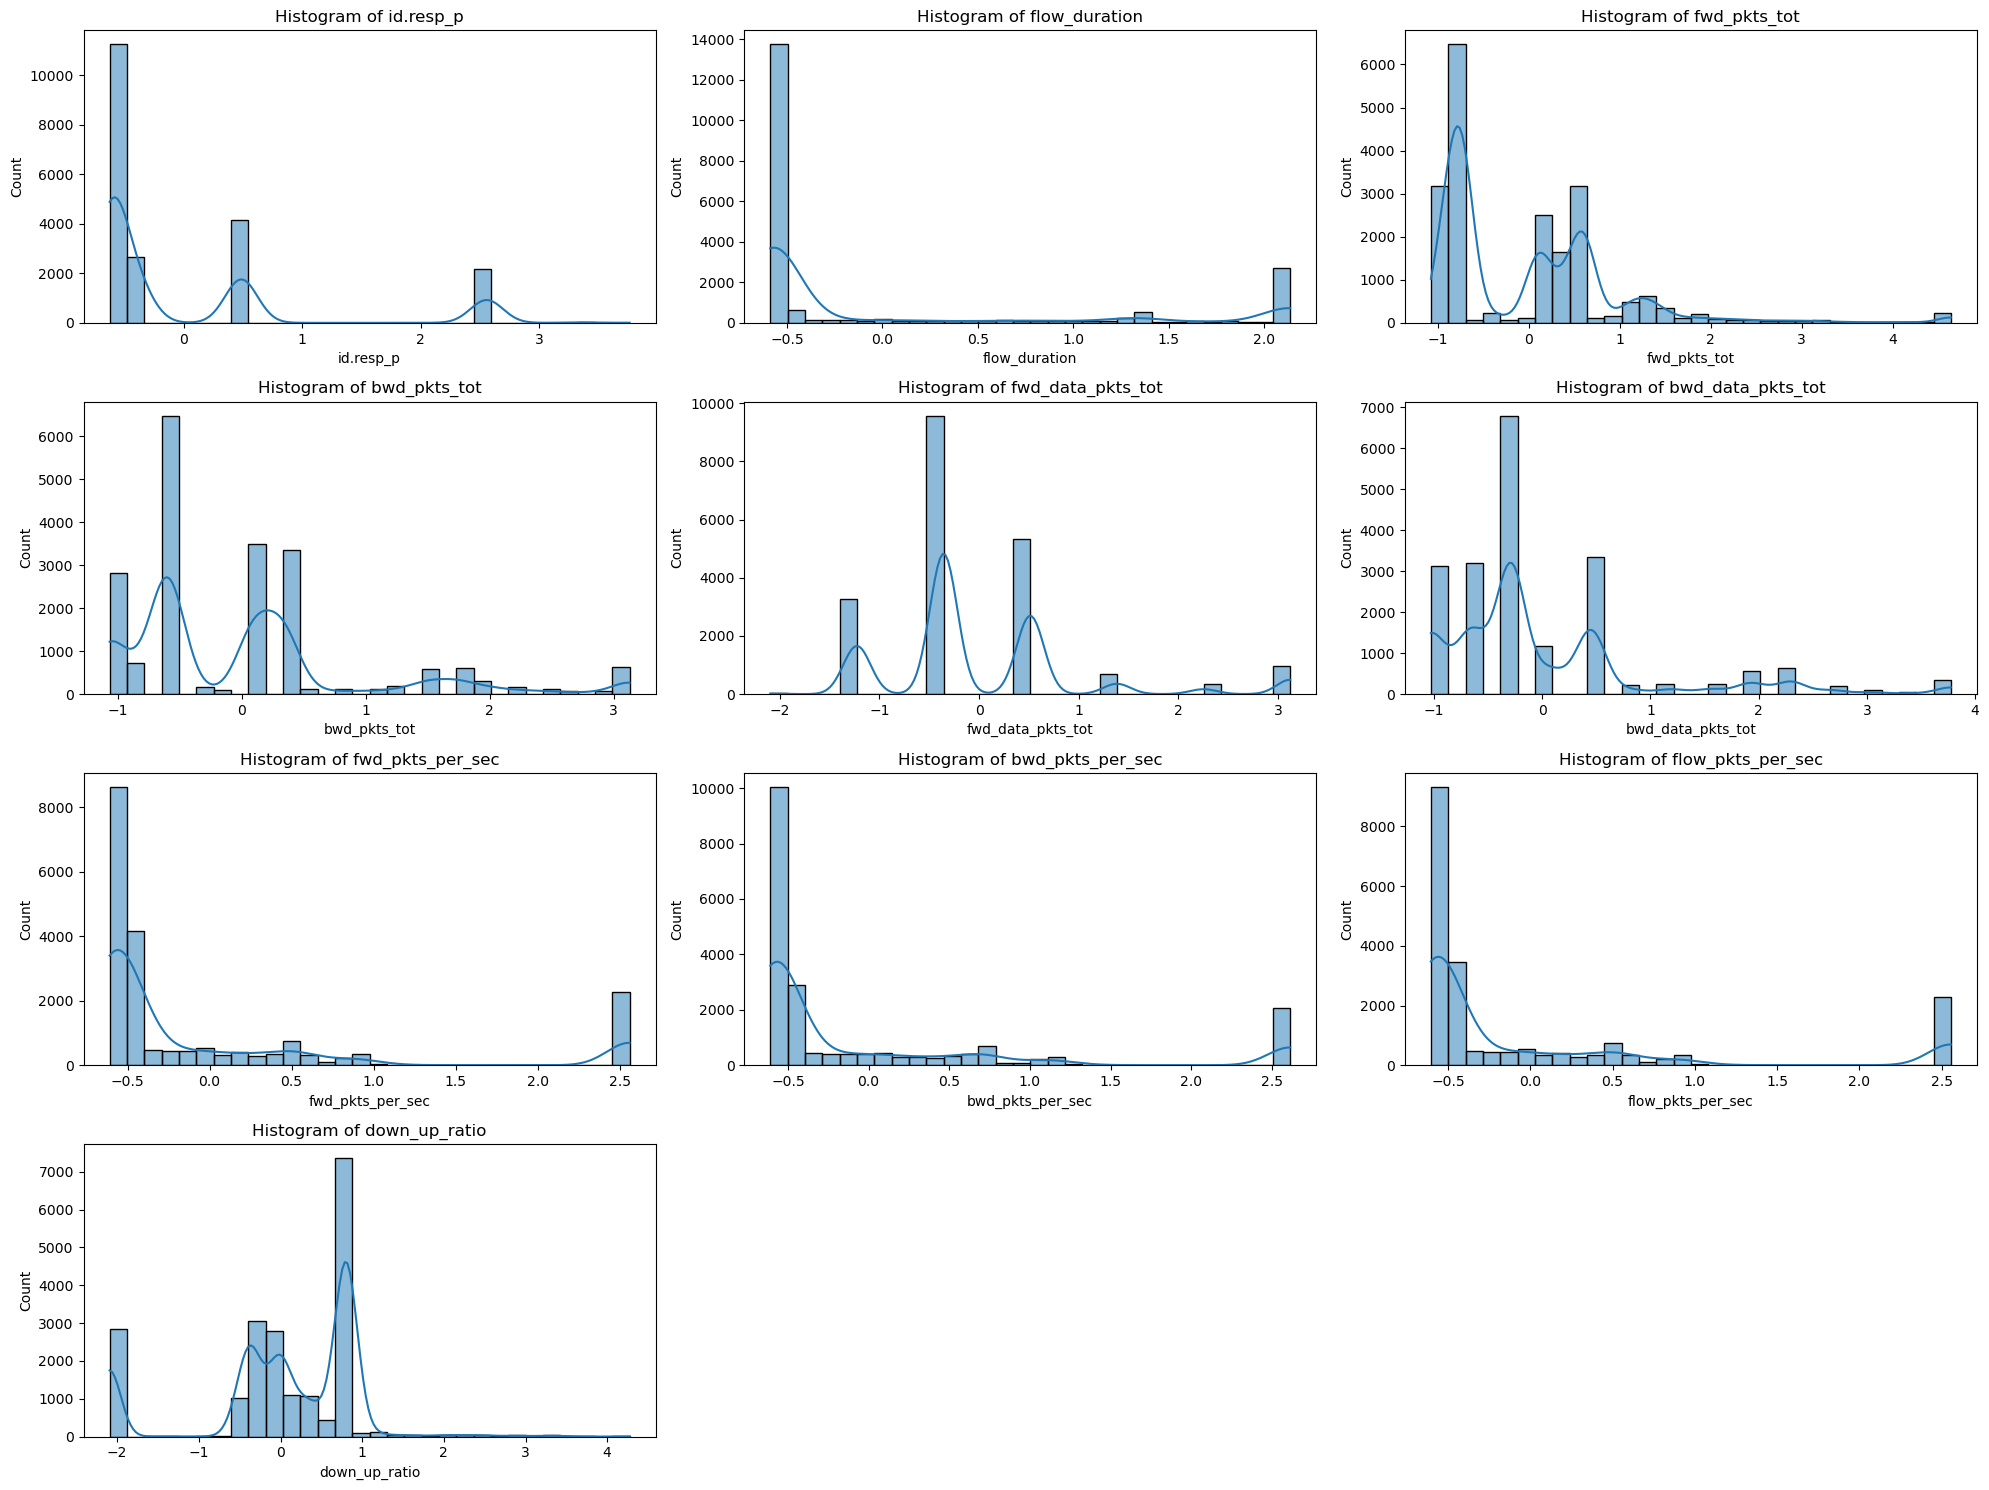

In [19]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(numeric_columns_sample, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"Histogram of {column}")
plt.tight_layout()
plt.show()

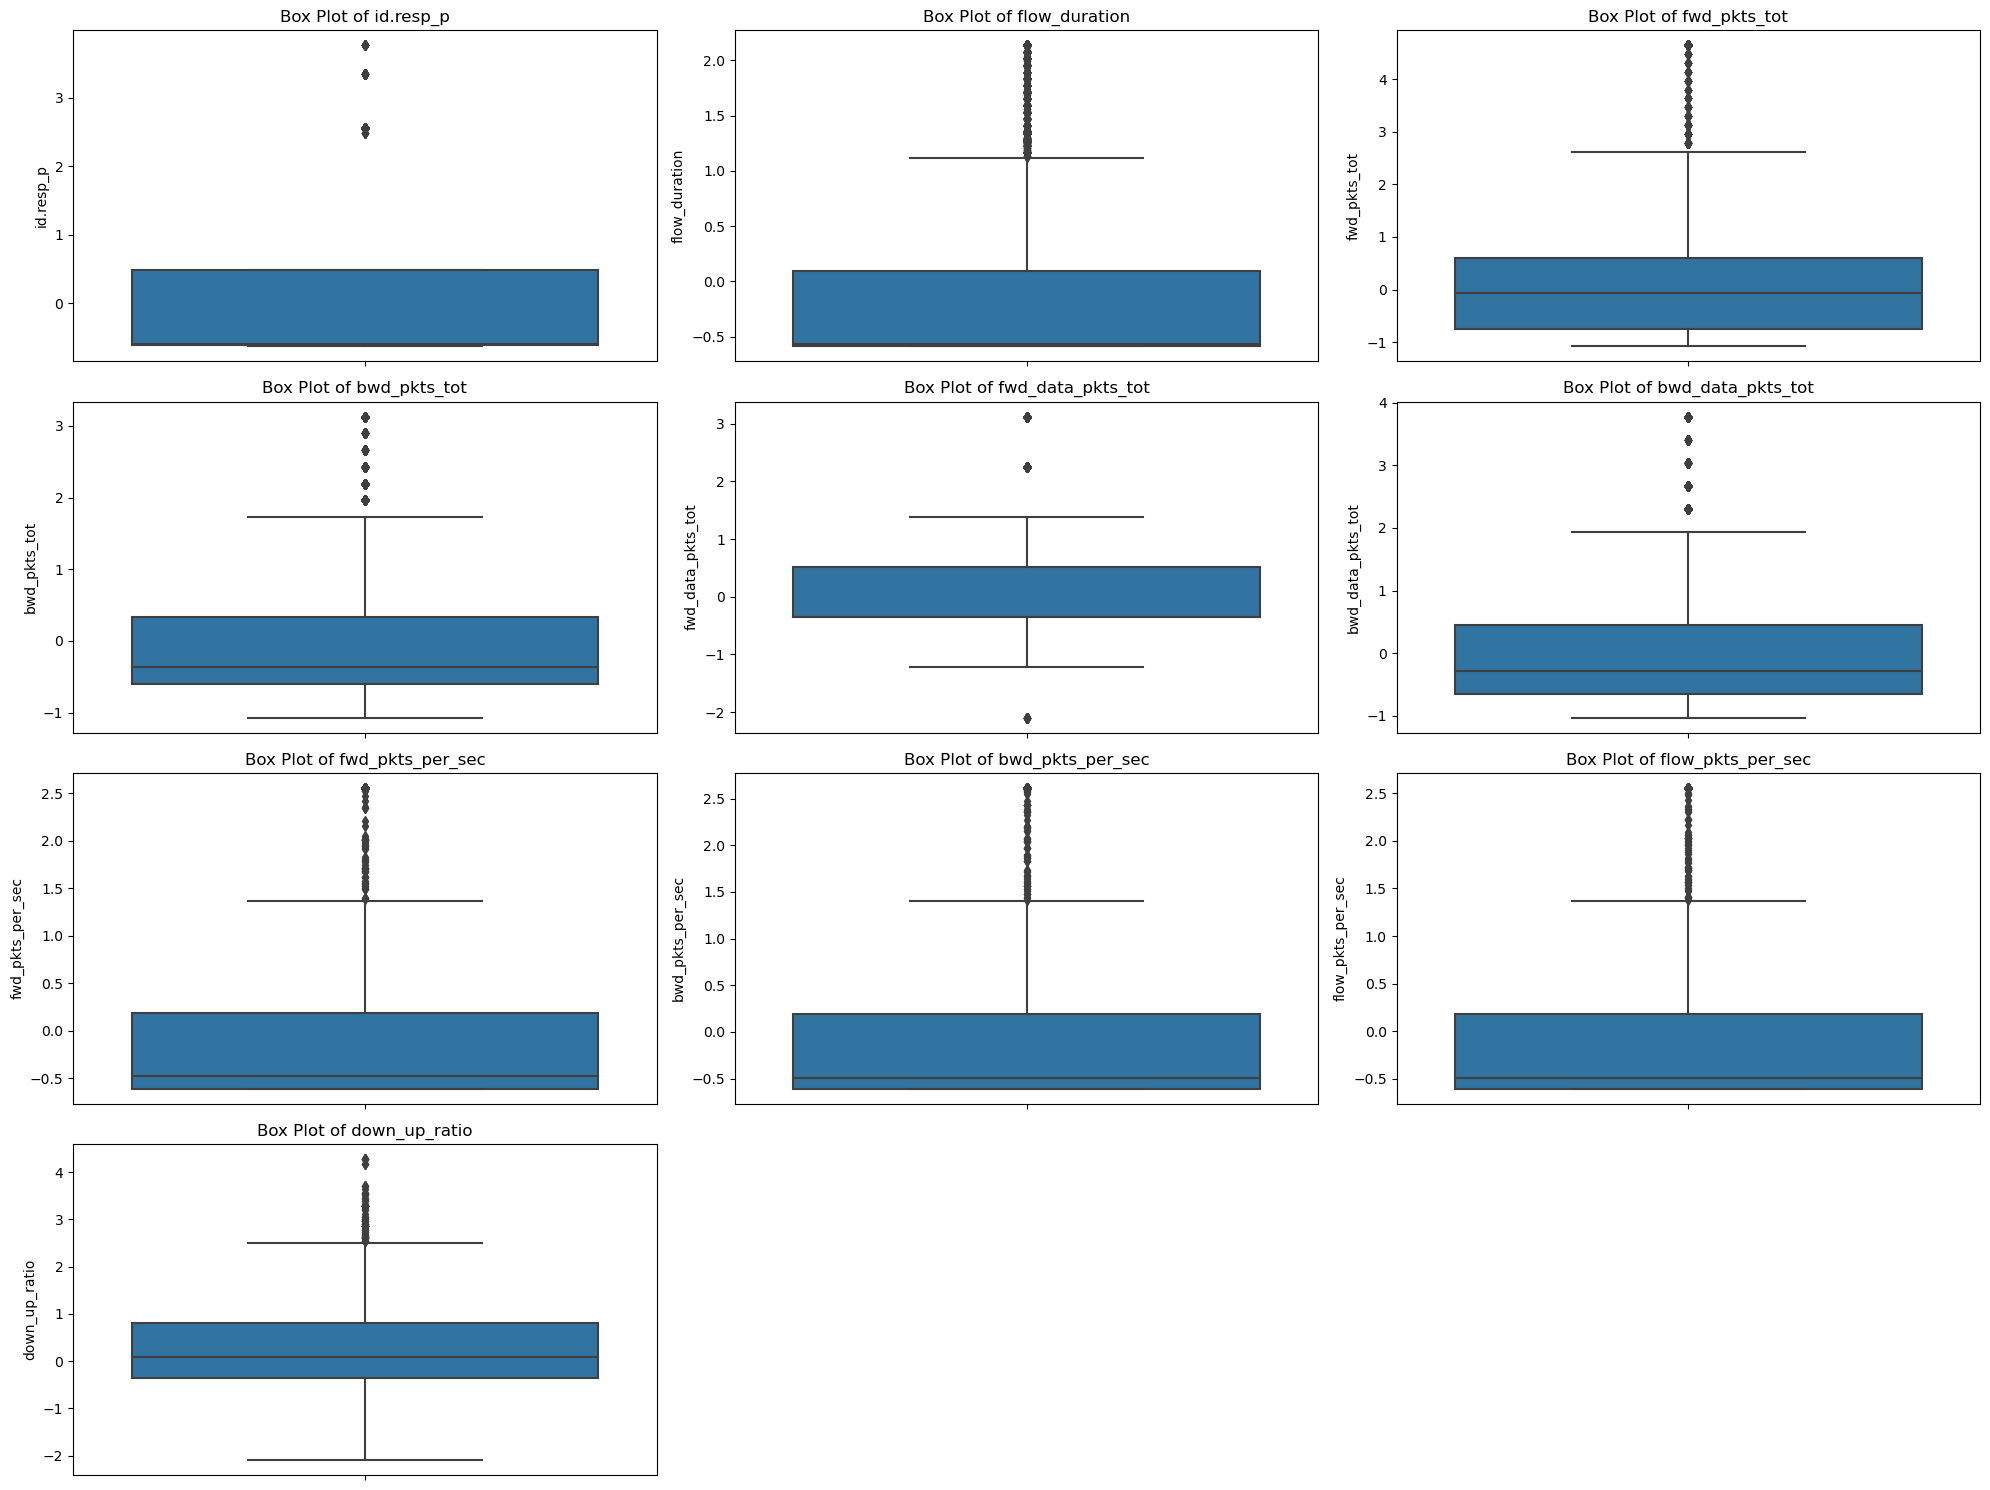

In [20]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(numeric_columns_sample, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f"Box Plot of {column}")
plt.tight_layout()
plt.show()

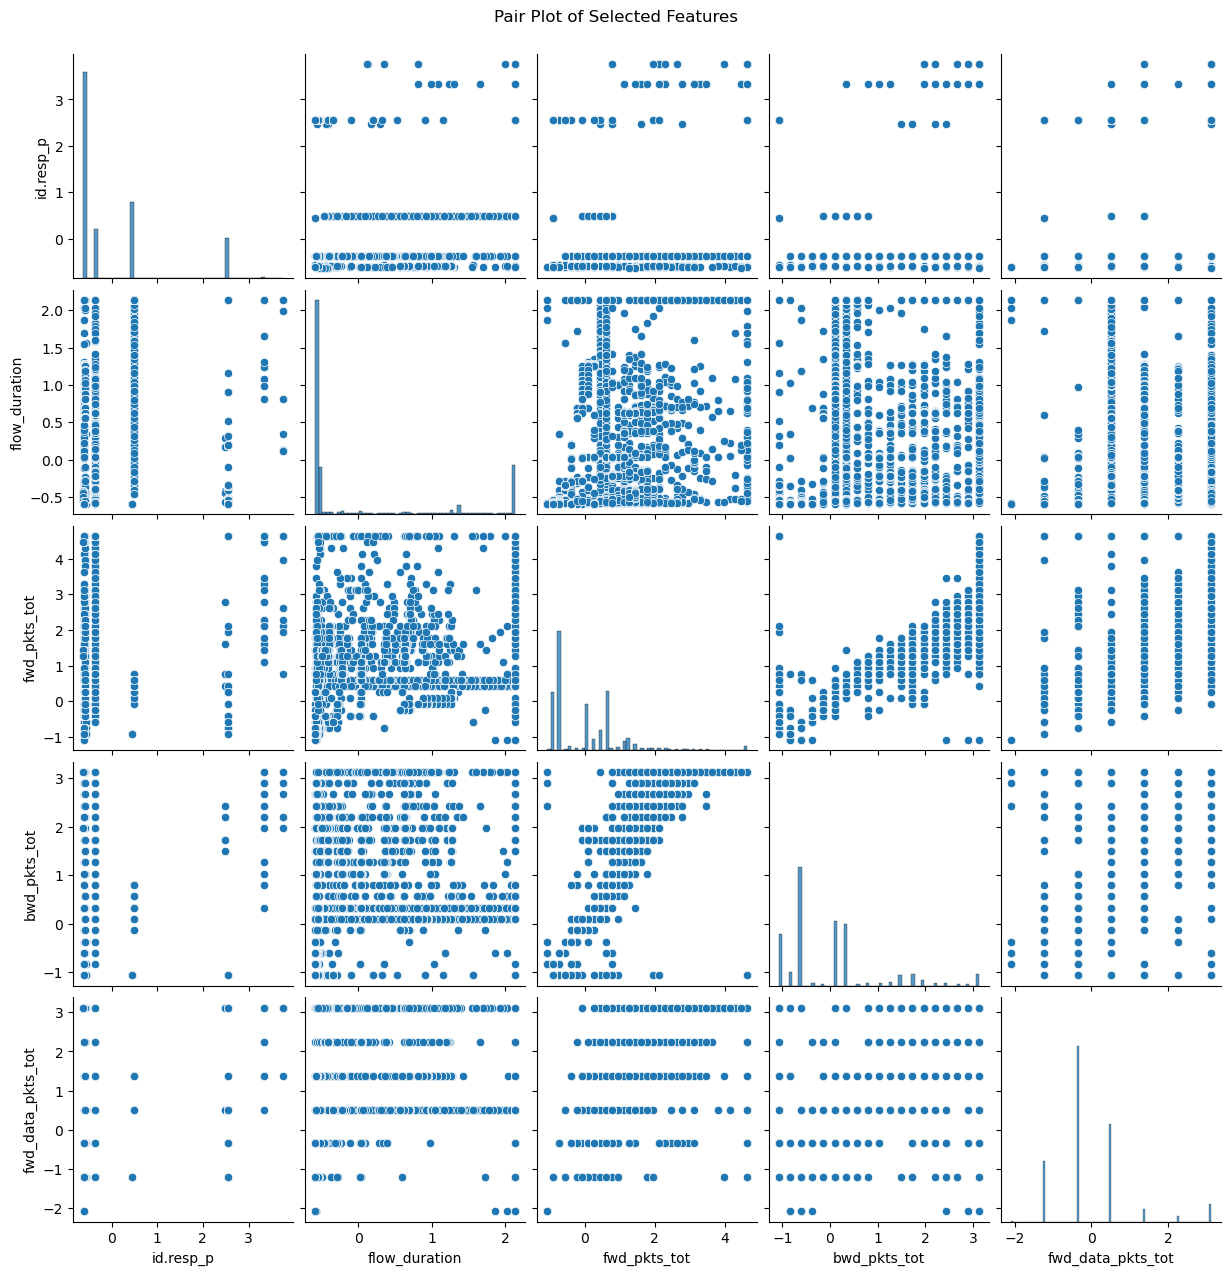

In [21]:
pair_plot_columns = numeric_columns_sample[:5]  # Limit to 5 features to avoid clutter
sns.pairplot(df[pair_plot_columns])
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()

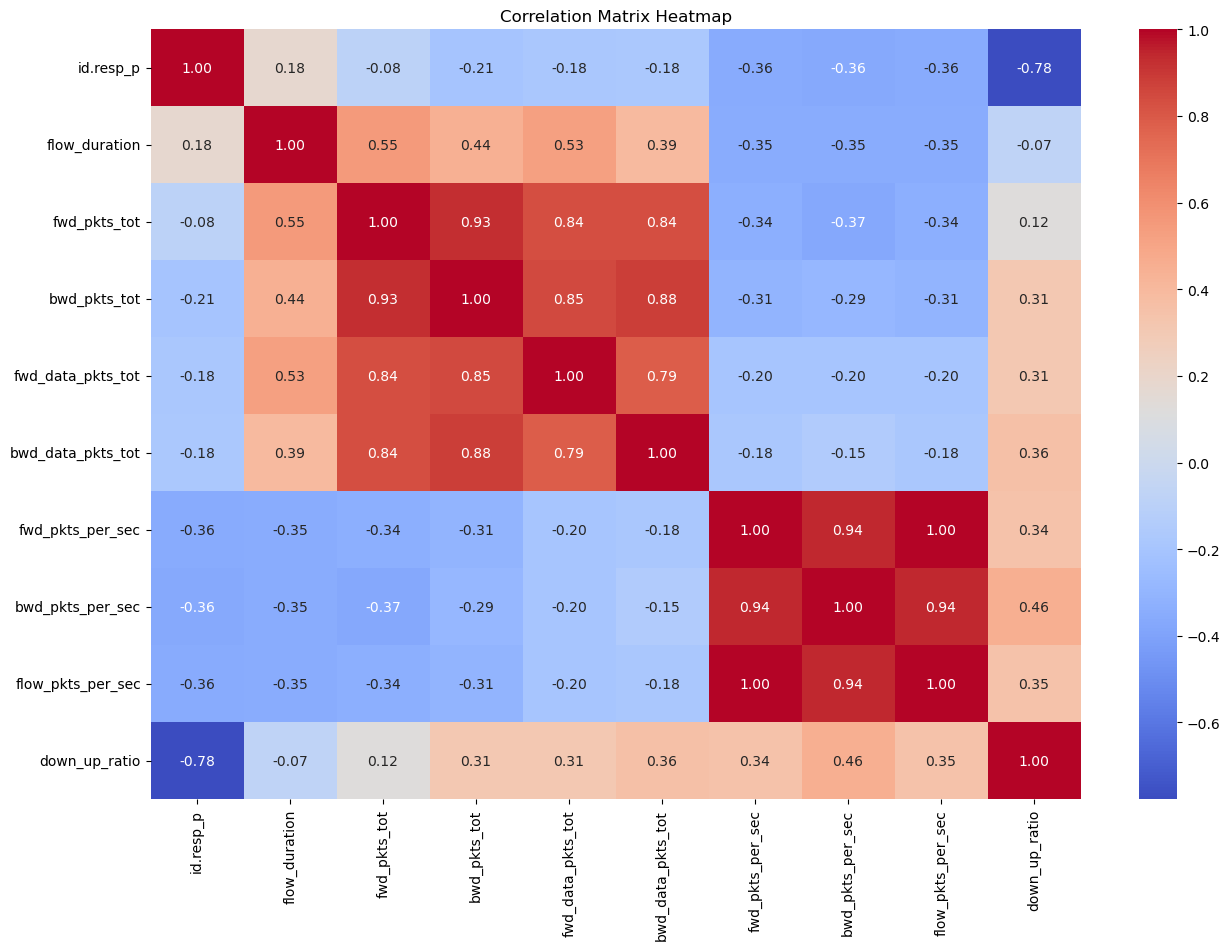

In [22]:
plt.figure(figsize=(15, 10))
correlation_matrix = df[numeric_columns_sample].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()



From the visualizations provided, we can observe several key characteristics of the dataset.

1. **Feature Distributions (Histograms and Box Plots)**:
   - Histograms reveal that many features, such as `flow_duration` and `fwd_pkts_per_sec`, are heavily skewed, with a significant concentration of values near zero and a long tail extending towards higher values.
   - The box plots highlight the presence of outliers in many features, such as `flow_duration`, `fwd_pkts_per_sec`, and `bwd_pkts_per_sec`. This confirms the need for capping or handling outliers, as was done during preprocessing.

2. **Relationships Between Features (Pair Plots)**:
   - The pair plots demonstrate some strong linear relationships between features. For instance, features like `fwd_pkts_tot` and `bwd_pkts_tot` show a clear correlation. This suggests that these features may convey redundant information, and dimensionality reduction techniques (e.g., feature selection or PCA) could be applied to improve model performance.

3. **Correlation Matrix (Heatmap)**:
   - The heatmap provides a detailed view of the correlations between numerical features. It confirms strong positive correlations between several pairs of features, such as `fwd_pkts_tot` and `bwd_pkts_tot`, as well as `bwd_data_pkts_tot` and `fwd_data_pkts_tot`.
   - Interestingly, some features, such as `id.resp_p`, have a notable negative correlation with others (e.g., `fwd_pkts_tot` and `down_up_ratio`). This might indicate that these features contribute contrasting information, which could be valuable for classification models.

### Insights:
- The dataset contains features with varying distributions, many of which are skewed and contain outliers. This could impact the performance of certain models, especially those sensitive to non-normal distributions (e.g., logistic regression).
- The strong correlations between some features suggest that feature selection or dimensionality reduction could be beneficial to avoid redundancy.
- Features with distinct distributions and outlier behavior might require special attention, such as applying transformation techniques (e.g., logarithmic scaling) to normalize their range.

These analyses provide a clear understanding of the data and its relationships, setting the stage for building effective classification and clustering models in the subsequent steps.


# Part 3: Implementing Classification Algorithms

### Step 1: Split the dataset

In [23]:
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=35)

### Step 2: Choose and Apply Three Algorithms

### Logistic Regression

In [24]:
########################################
# Classification Algorithm 1: Logistic Regression (From Scratch)
########################################

class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        # One-vs-Rest for multi-class:
        self.classes_ = np.unique(y)
        self.W = {}
        self.b = {}
        # Convert y to numeric classes
        y_numeric = pd.Categorical(y, categories=self.classes_).codes

        n_samples, n_features = X.shape
        for c in self.classes_:
            # Create a binary problem for class c
            y_binary = (y == c).astype(int)
            w = np.zeros(n_features)
            b = 0
            
            for _ in range(self.n_iter):
                linear_model = np.dot(X, w) + b
                y_pred = self._sigmoid(linear_model)
                
                dw = (1/n_samples)*np.dot(X.T, (y_pred - y_binary))
                db = (1/n_samples)*np.sum(y_pred - y_binary)
                
                w -= self.lr * dw
                b -= self.lr * db
            
            self.W[c] = w
            self.b[c] = b
    
    def predict(self, X):
        scores = []
        for c in self.classes_:
            linear_model = np.dot(X, self.W[c]) + self.b[c]
            scores.append(self._sigmoid(linear_model))
        scores = np.array(scores)
        class_indices = np.argmax(scores, axis=0)
        return self.classes_[class_indices]


### Decision Tree

In [25]:
########################################
# Classification Algorithm 2: Decision Tree (From Scratch)
########################################

class DecisionTreeScratch:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return -np.sum(p * np.log2(p))
    
    def _best_split(self, X, y):
        # Choose best feature and threshold to split on
        best_gain = 0
        best_feature = None
        best_threshold = None
        current_entropy = self._entropy(y)
        n_samples, n_features = X.shape
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                y_left = y[X[:, feature] <= t]
                y_right = y[X[:, feature] > t]
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                p_left = len(y_left) / len(y)
                p_right = 1 - p_left
                gain = current_entropy - (p_left*self._entropy(y_left) + p_right*self._entropy(y_right))
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = t
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        # Create leaf if stopping criteria met
        if depth >= self.max_depth or len(X) < self.min_samples_split or len(np.unique(y)) == 1:
            return np.argmax(np.bincount(pd.Categorical(y, categories=self.classes_).codes))

        feature, threshold, gain = self._best_split(X, y)
        if gain == 0:
            return np.argmax(np.bincount(pd.Categorical(y, categories=self.classes_).codes))
        
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx
        
        left_branch = self._build_tree(X[left_idx], y[left_idx], depth+1)
        right_branch = self._build_tree(X[right_idx], y[right_idx], depth+1)
        
        return (feature, threshold, left_branch, right_branch)
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.tree_ = self._build_tree(X, y)
    
    def _predict_one(self, x, node):
        if not isinstance(node, tuple):
            return self.classes_[node]
        feature, threshold, left_branch, right_branch = node
        if x[feature] <= threshold:
            return self._predict_one(x, left_branch)
        else:
            return self._predict_one(x, right_branch)
    
    def predict(self, X):
        return np.array([self._predict_one(x, self.tree_) for x in X])


### K-Nearest Neighbors

In [26]:
########################################
# Classification Algorithm 3: K-NN (From Scratch)
########################################

class KNNClassifierScratch:
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)
    
    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            idx = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[idx]
            counts = np.bincount(pd.Categorical(nearest_labels, categories=self.classes_).codes)
            y_pred.append(self.classes_[np.argmax(counts)])
        return np.array(y_pred)


### Step 3: Evaluating the Models

In [27]:
def confusion_matrix_scratch(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm

def classification_report_scratch(y_true, y_pred, average='macro'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

Logistic Regression Classification Report:
Accuracy: 0.9530864197530864
Precision (macro): 0.7439347469398904
Recall (macro): 0.708541021928376
F1-score (macro): 0.7174845352457403


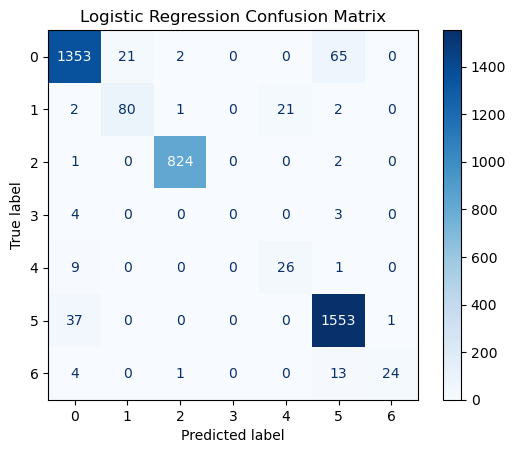

In [28]:
########################################
# Train and Evaluate Logistic Regression
########################################
lr_model = LogisticRegressionScratch(lr=0.01, n_iter=3000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


print("Logistic Regression Classification Report:")
lr_cm = confusion_matrix_scratch(y_test, y_pred_lr)
lr_acc, lr_prec, lr_rec, lr_f1 = classification_report_scratch(y_test, y_pred_lr, average='macro')
print("Accuracy:", lr_acc)
print("Precision (macro):", lr_prec)
print("Recall (macro):", lr_rec)
print("F1-score (macro):", lr_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

K-NN Classification Report:
Accuracy: 0.9841975308641975
Precision (macro): 0.9847615098288953
Recall (macro): 0.8738966138222316
F1-score (macro): 0.9114903954306408


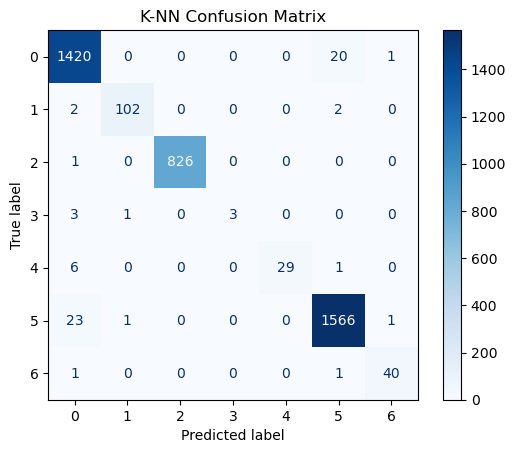

In [29]:
########################################
# Train and Evaluate K-NN
########################################
knn_model = KNNClassifierScratch(k=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

knn_cm = confusion_matrix_scratch(y_test, y_pred_knn)
knn_acc, knn_prec, knn_rec, knn_f1 = classification_report_scratch(y_test, y_pred_knn, average='macro')


print("K-NN Classification Report:")
print("Accuracy:", knn_acc)
print("Precision (macro):", knn_prec)
print("Recall (macro):", knn_rec)
print("F1-score (macro):", knn_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
disp.plot(cmap='Blues')
plt.title("K-NN Confusion Matrix")
plt.show()

In [30]:
########################################
# Train and Evaluate Decision Tree
########################################
dt_model = DecisionTreeScratch(max_depth=10, min_samples_split=5)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)



dt_cm = confusion_matrix_scratch(y_test, y_pred_dt)
dt_acc, dt_prec, dt_rec, dt_f1 = classification_report_scratch(y_test, y_pred_dt, average='macro')



Decision Tree Classification Report:
Accuracy: 0.9869135802469136
Precision (macro): 0.9825506381457748
Recall (macro): 0.8860275823326985
F1-score (macro): 0.9177790673360742


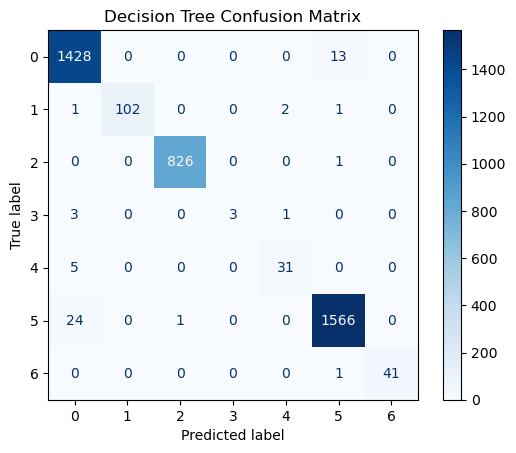

In [31]:
print("Decision Tree Classification Report:")
print("Accuracy:", dt_acc)
print("Precision (macro):", dt_prec)
print("Recall (macro):", dt_rec)
print("F1-score (macro):", dt_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm)
disp.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

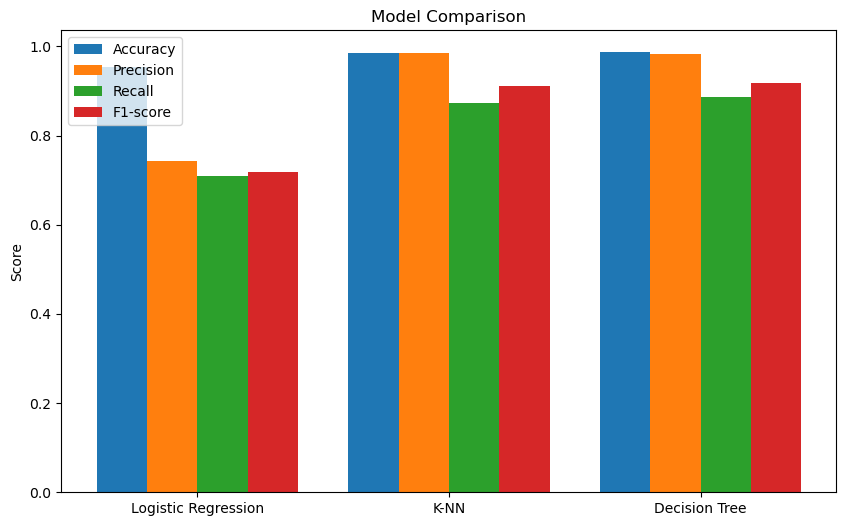

In [32]:
models = ['Logistic Regression', 'K-NN', 'Decision Tree']
accuracies = [lr_acc, knn_acc, dt_acc]
precisions = [lr_prec, knn_prec, dt_prec]
recalls = [lr_rec, knn_rec, dt_rec]
f1_scores = [lr_f1, knn_f1, dt_f1]

# Bar plot of metrics
x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(10,6))
plt.bar(x - 0.3, accuracies, width, label='Accuracy')
plt.bar(x - 0.1, precisions, width, label='Precision')
plt.bar(x + 0.1, recalls, width, label='Recall')
plt.bar(x + 0.3, f1_scores, width, label='F1-score')
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Model Comparison")
plt.legend()
plt.show()


### Step 4: Further Preprocessing

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df.sort_values('importance', ascending=False, inplace=True)

print("Top 50 most important features:")
print(feature_importance_df.head(50))

Top 50 most important features:
                     feature  importance
44               fwd_iat.min    0.093340
54              flow_iat.min    0.087843
32      fwd_pkts_payload.avg    0.082260
40     flow_pkts_payload.max    0.043819
62         fwd_subflow_bytes    0.039968
42     flow_pkts_payload.avg    0.039437
82      fwd_last_window_size    0.036003
73                active.avg    0.032821
29      fwd_pkts_payload.min    0.032818
70                active.min    0.029011
45               fwd_iat.max    0.027578
39     flow_pkts_payload.min    0.024748
46               fwd_iat.tot    0.023360
71                active.max    0.022997
55              flow_iat.max    0.020444
57              flow_iat.avg    0.019384
47               fwd_iat.avg    0.018165
4              flow_duration    0.015148
41     flow_pkts_payload.tot    0.015143
72                active.tot    0.014823
0                  id.orig_p    0.014516
1                  id.resp_p    0.014384
30      fwd_pkts_payload.

In [34]:
top_features = feature_importance_df.head(34)['feature'].values

In [35]:
top_features

array(['fwd_iat.min', 'flow_iat.min', 'fwd_pkts_payload.avg',
       'flow_pkts_payload.max', 'fwd_subflow_bytes',
       'flow_pkts_payload.avg', 'fwd_last_window_size', 'active.avg',
       'fwd_pkts_payload.min', 'active.min', 'fwd_iat.max',
       'flow_pkts_payload.min', 'fwd_iat.tot', 'active.max',
       'flow_iat.max', 'flow_iat.avg', 'fwd_iat.avg', 'flow_duration',
       'flow_pkts_payload.tot', 'active.tot', 'id.orig_p', 'id.resp_p',
       'fwd_pkts_payload.max', 'bwd_pkts_per_sec',
       'flow_pkts_payload.std', 'fwd_PSH_flag_count', 'fwd_data_pkts_tot',
       'bwd_iat.avg', 'bwd_iat.max', 'bwd_pkts_payload.max',
       'bwd_pkts_payload.std', 'bwd_iat.std', 'flow_iat.tot',
       'payload_bytes_per_second'], dtype=object)

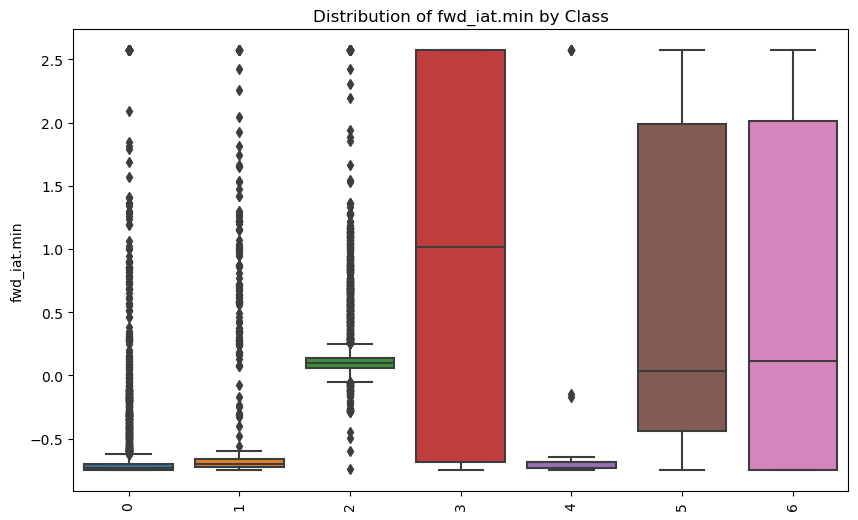

0   -0.643609
4   -0.606417
1   -0.372306
2    0.171672
5    0.513970
6    0.535638
3    0.953156
Name: fwd_iat.min, dtype: float64


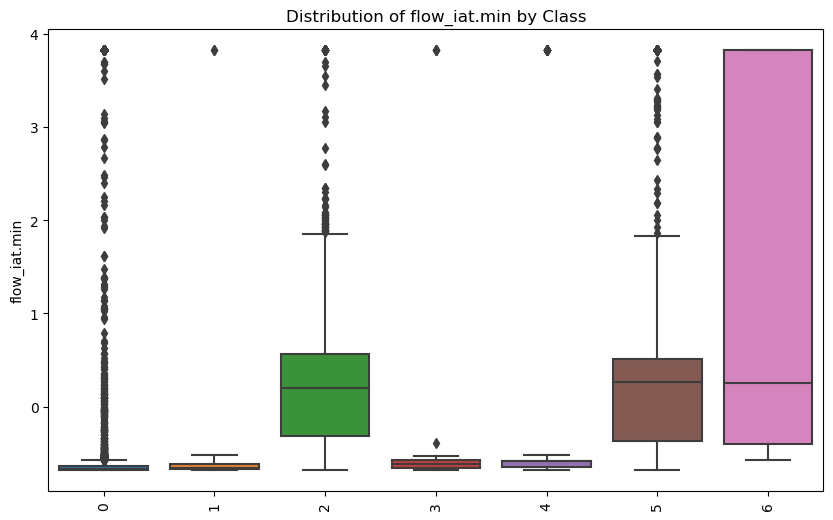

1   -0.623184
0   -0.473878
4   -0.289233
3   -0.136707
2    0.227453
5    0.322593
6    1.342540
Name: flow_iat.min, dtype: float64


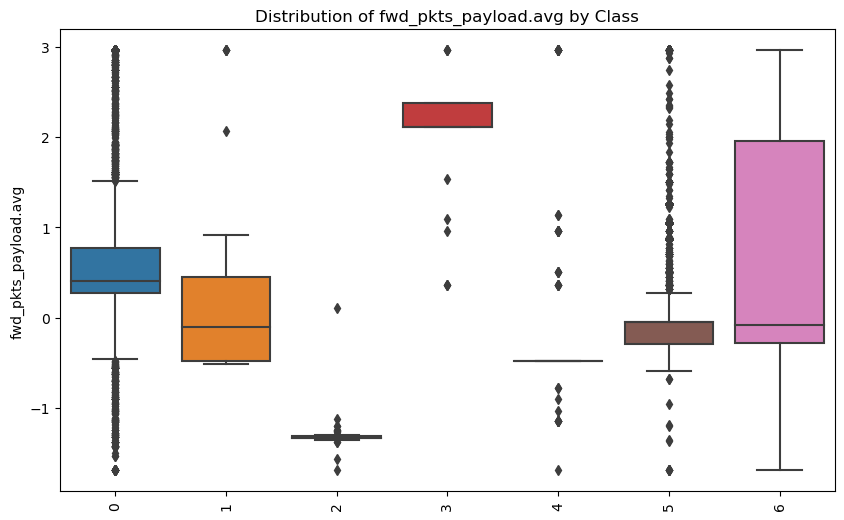

2   -1.330529
4   -0.173732
1   -0.039355
5    0.031846
6    0.553534
0    0.708530
3    2.072669
Name: fwd_pkts_payload.avg, dtype: float64


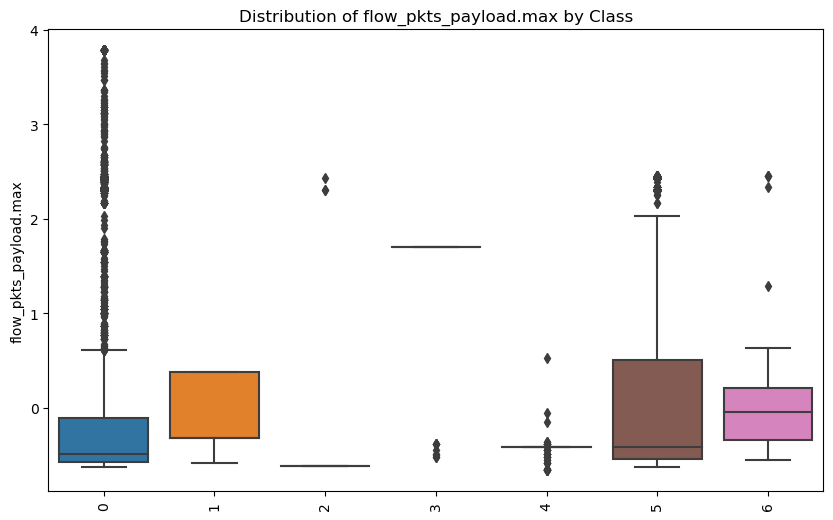

2   -0.613353
4   -0.423459
1   -0.134965
6   -0.024651
0    0.125249
5    0.219421
3    1.180823
Name: flow_pkts_payload.max, dtype: float64


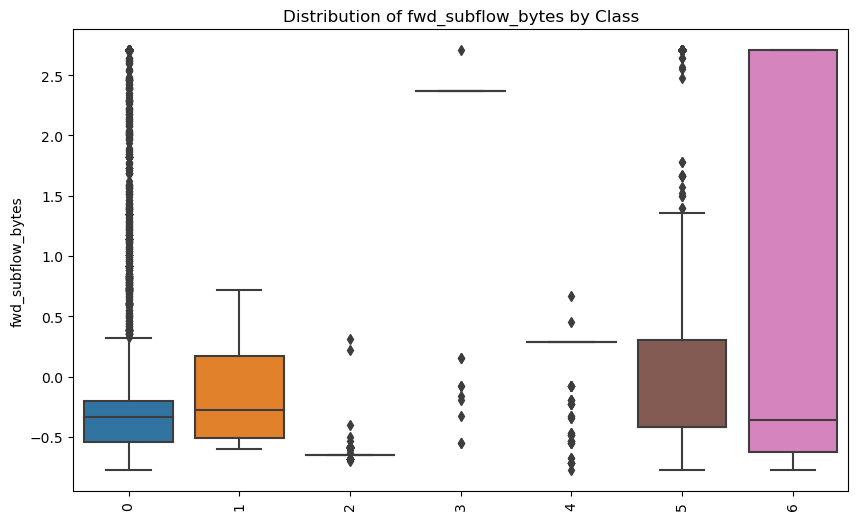

2   -0.647847
1   -0.149422
0    0.094337
4    0.131533
5    0.230047
6    0.779716
3    1.755265
Name: fwd_subflow_bytes, dtype: float64


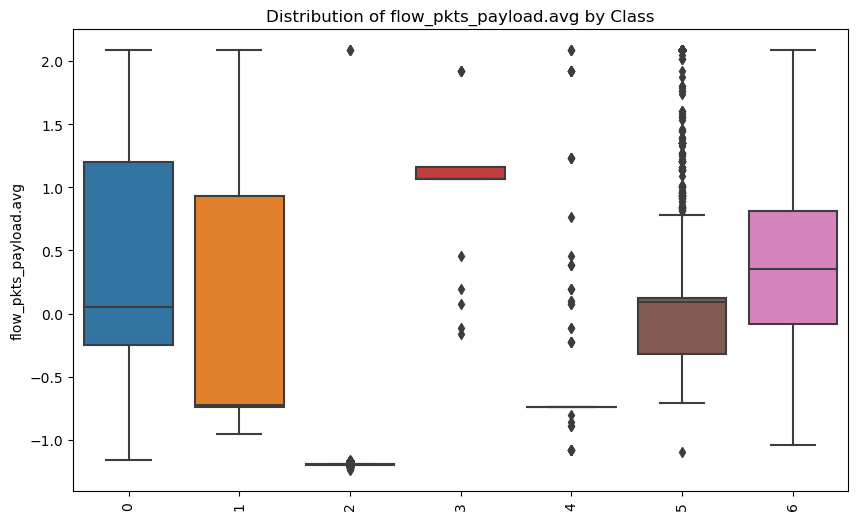

2   -1.188718
4   -0.485710
1   -0.164101
5    0.198699
6    0.232250
0    0.474639
3    1.058896
Name: flow_pkts_payload.avg, dtype: float64


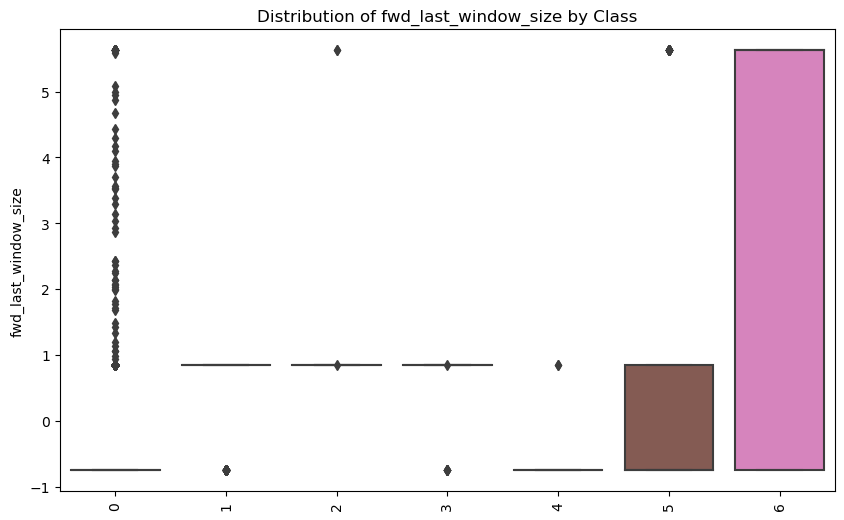

4   -0.737614
0   -0.404529
5   -0.194208
3    0.494851
1    0.545279
2    0.845144
6    3.815092
Name: fwd_last_window_size, dtype: float64


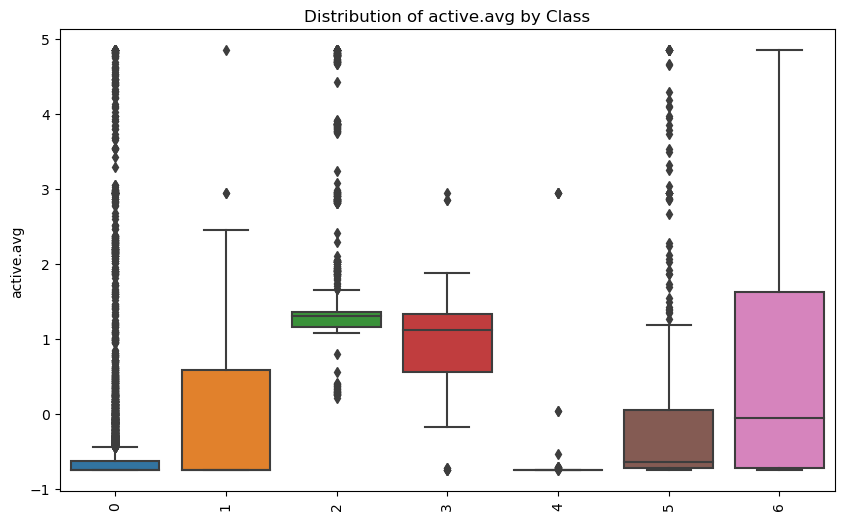

4   -0.659565
0   -0.484218
5   -0.275178
1   -0.111658
6    0.794720
3    0.937641
2    1.368249
Name: active.avg, dtype: float64


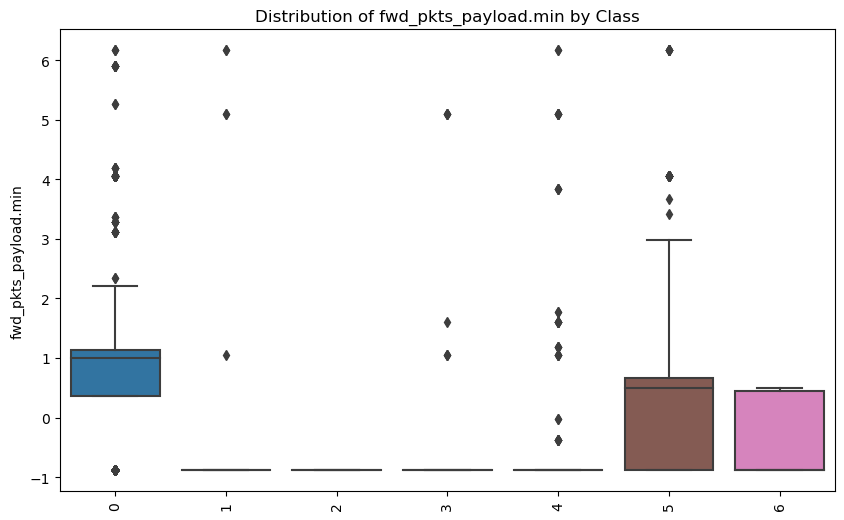

2   -0.887967
1   -0.834948
6   -0.548088
4   -0.245825
5   -0.055144
3   -0.017473
0    0.652716
Name: fwd_pkts_payload.min, dtype: float64


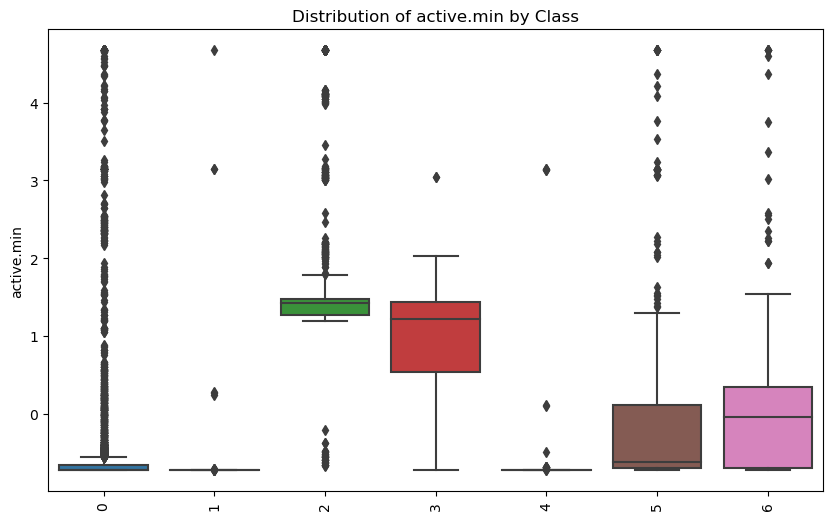

1   -0.697556
4   -0.630192
0   -0.528437
5   -0.236102
6    0.118980
3    0.959066
2    1.477349
Name: active.min, dtype: float64


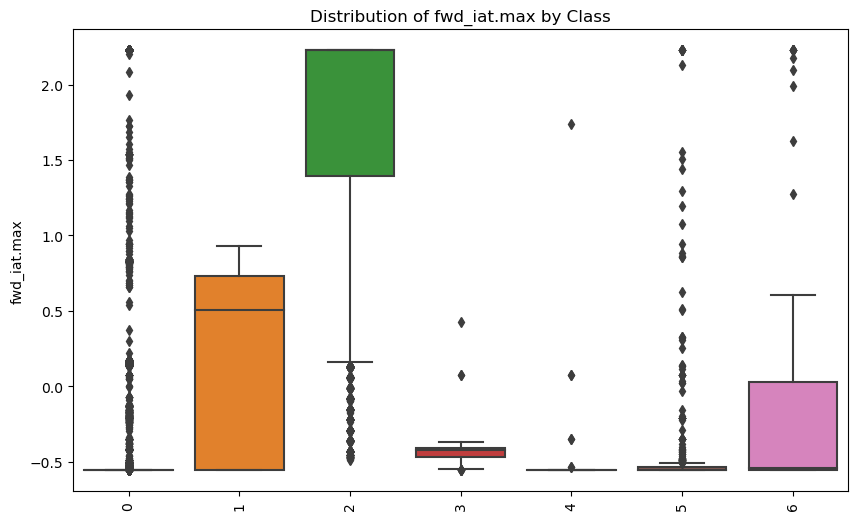

5   -0.539212
4   -0.535928
3   -0.399736
0   -0.336318
6   -0.227406
1    0.091154
2    1.651175
Name: fwd_iat.max, dtype: float64


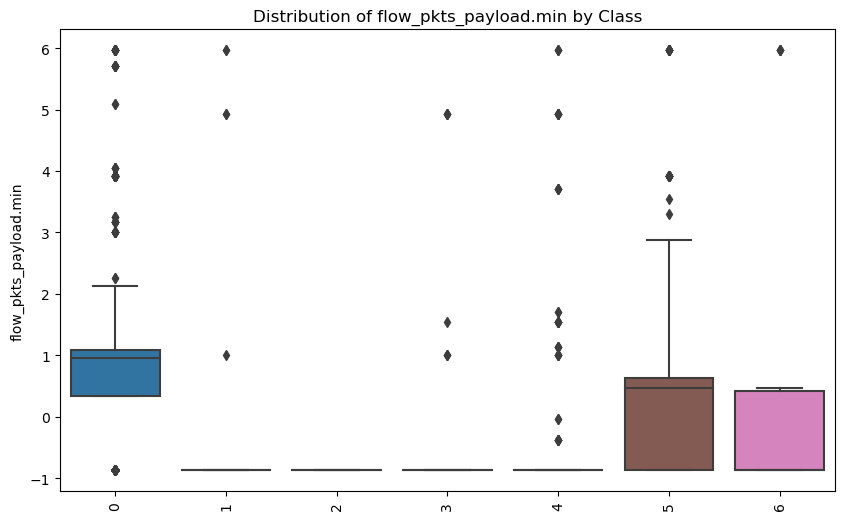

2   -0.872600
1   -0.821204
6   -0.378788
4   -0.211920
5   -0.060113
3   -0.028751
0    0.642751
Name: flow_pkts_payload.min, dtype: float64


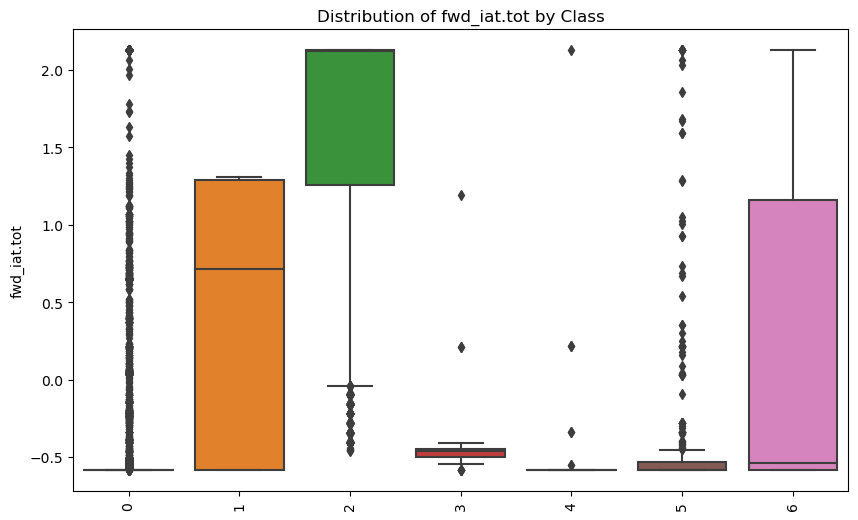

4   -0.559599
5   -0.547129
3   -0.402756
0   -0.301329
6    0.172425
1    0.323830
2    1.556717
Name: fwd_iat.tot, dtype: float64


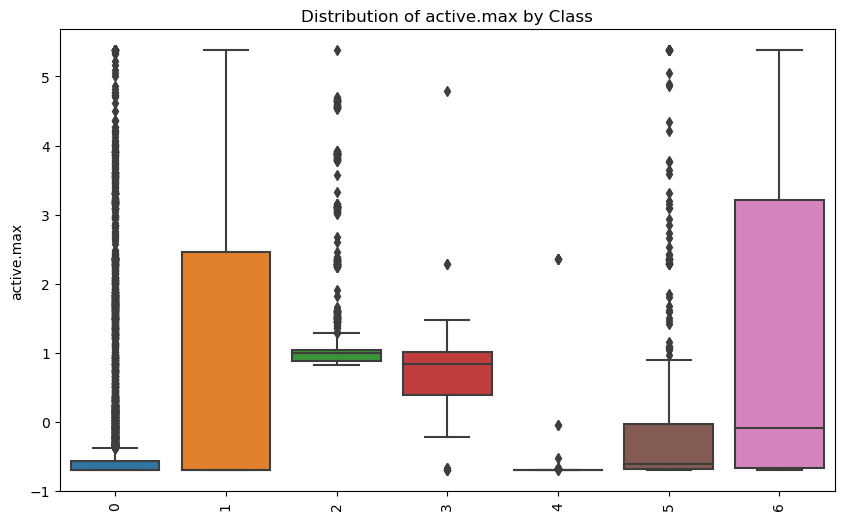

4   -0.627514
0   -0.348148
5   -0.302941
1    0.666130
3    0.759271
2    1.060961
6    1.283463
Name: active.max, dtype: float64


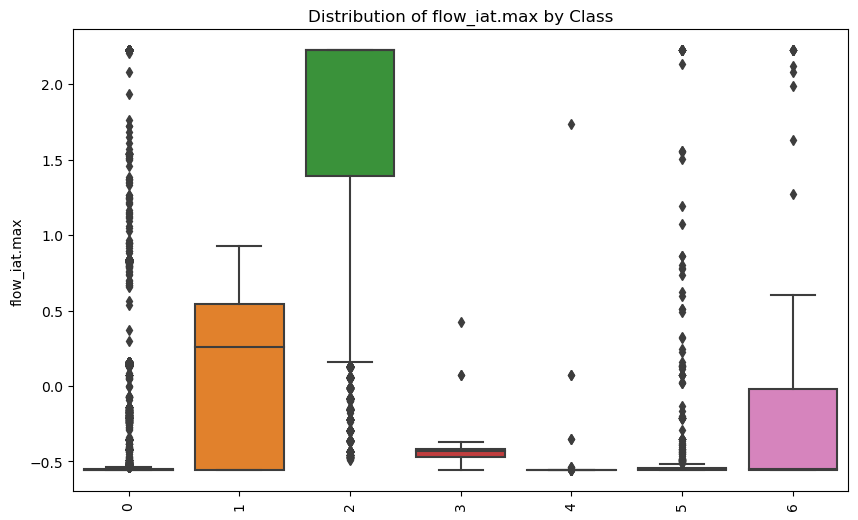

5   -0.537133
4   -0.536415
3   -0.402728
0   -0.334227
6   -0.236212
1    0.046464
2    1.649728
Name: flow_iat.max, dtype: float64


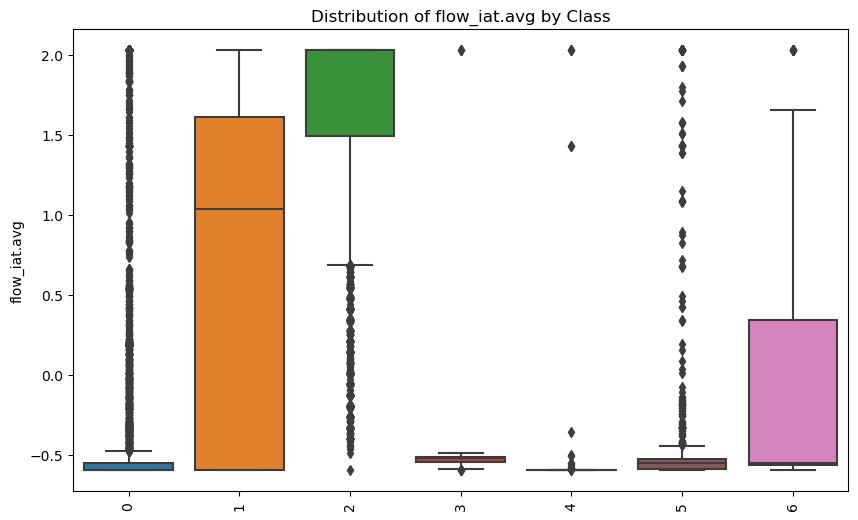

5   -0.537376
4   -0.527144
0   -0.354338
3   -0.326111
6   -0.134758
1    0.554601
2    1.614156
Name: flow_iat.avg, dtype: float64


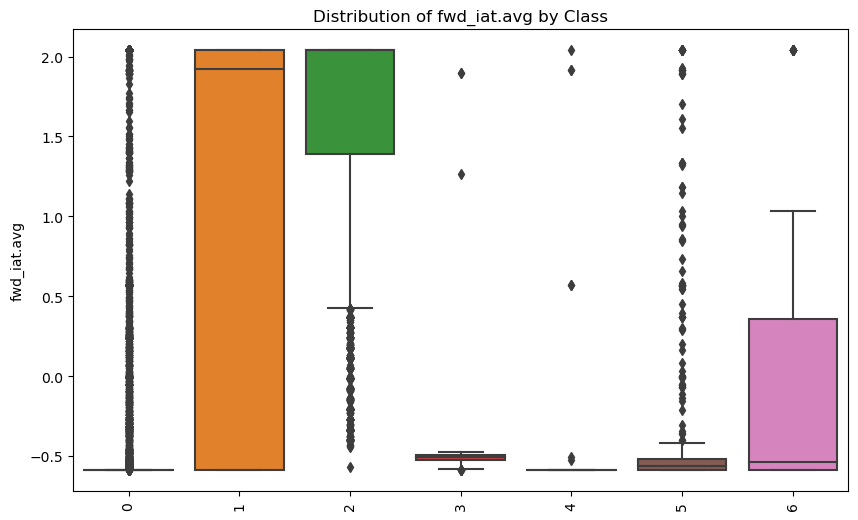

5   -0.538828
4   -0.533701
0   -0.351435
3   -0.341779
6   -0.118231
1    0.800701
2    1.580080
Name: fwd_iat.avg, dtype: float64


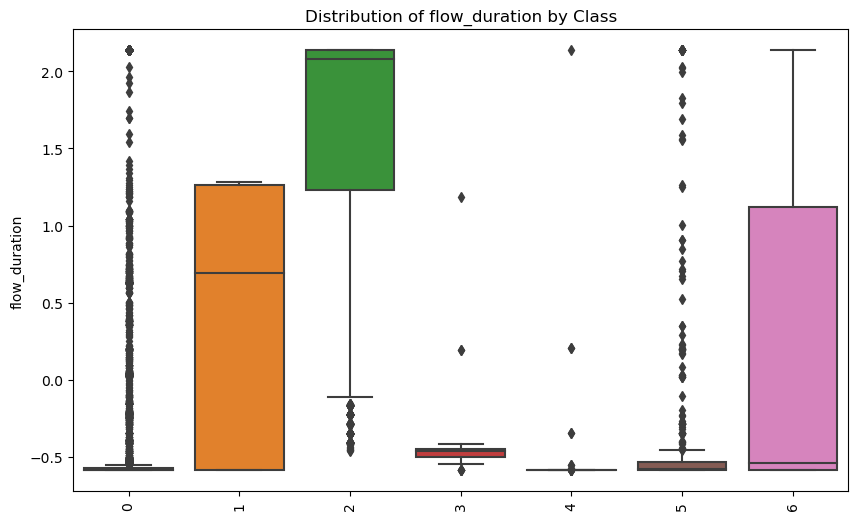

4   -0.560159
5   -0.543764
3   -0.405671
0   -0.299398
6    0.165276
1    0.309583
2    1.549106
Name: flow_duration, dtype: float64


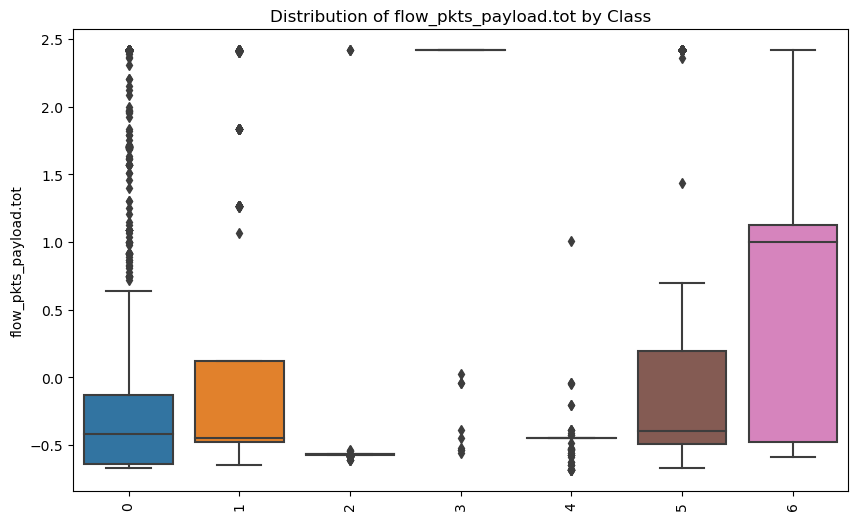

2   -0.566768
4   -0.455429
5    0.138331
0    0.143766
1    0.163531
6    0.679539
3    1.745223
Name: flow_pkts_payload.tot, dtype: float64


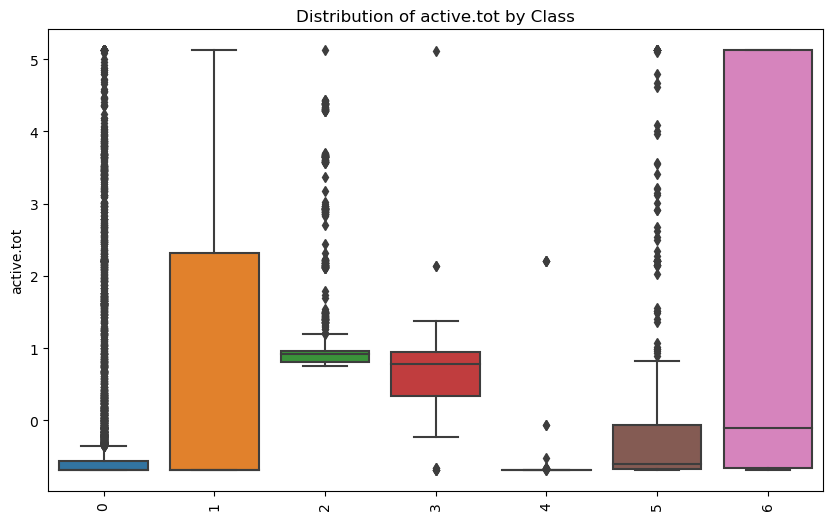

4   -0.617858
5   -0.308191
0   -0.297803
1    0.613109
3    0.713394
2    0.985414
6    1.377088
Name: active.tot, dtype: float64


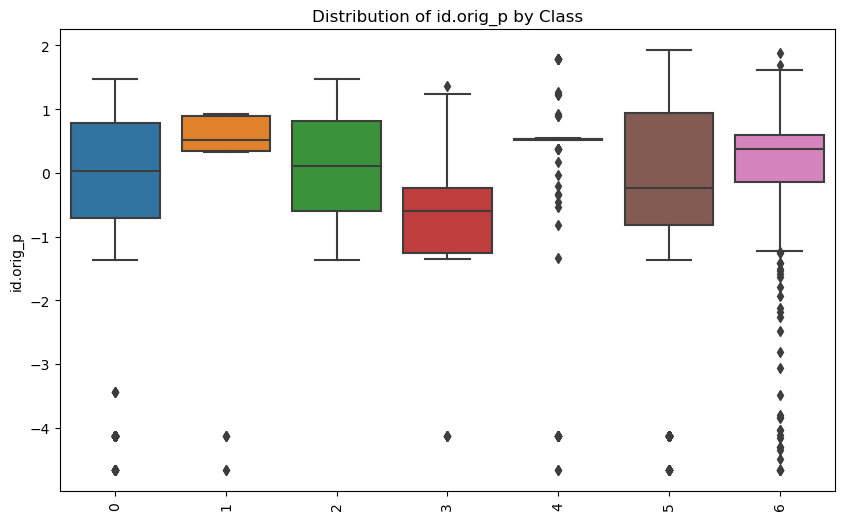

3   -0.905393
5   -0.071972
6   -0.044991
0   -0.014472
2    0.092276
4    0.172272
1    0.578075
Name: id.orig_p, dtype: float64


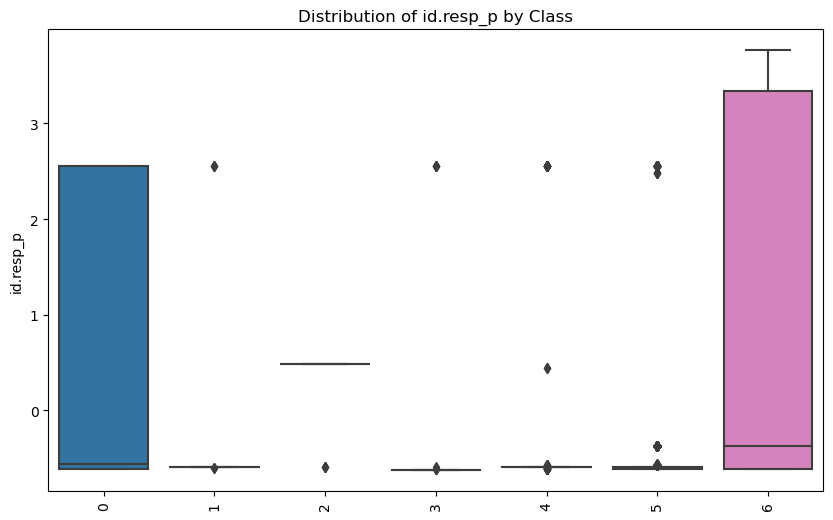

1   -0.573662
5   -0.526007
3   -0.279122
4   -0.264114
0    0.336834
2    0.484167
6    0.587407
Name: id.resp_p, dtype: float64


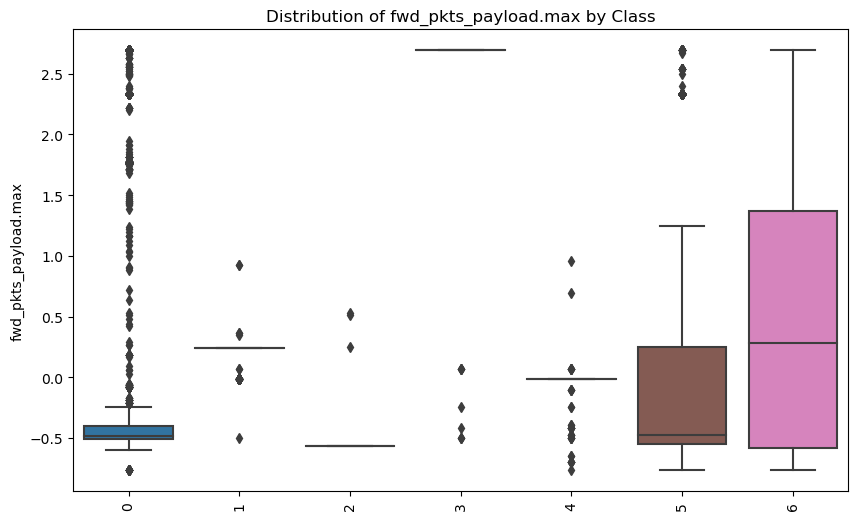

2   -0.569330
4   -0.087388
5    0.118553
0    0.159492
1    0.196431
6    0.496717
3    1.986260
Name: fwd_pkts_payload.max, dtype: float64


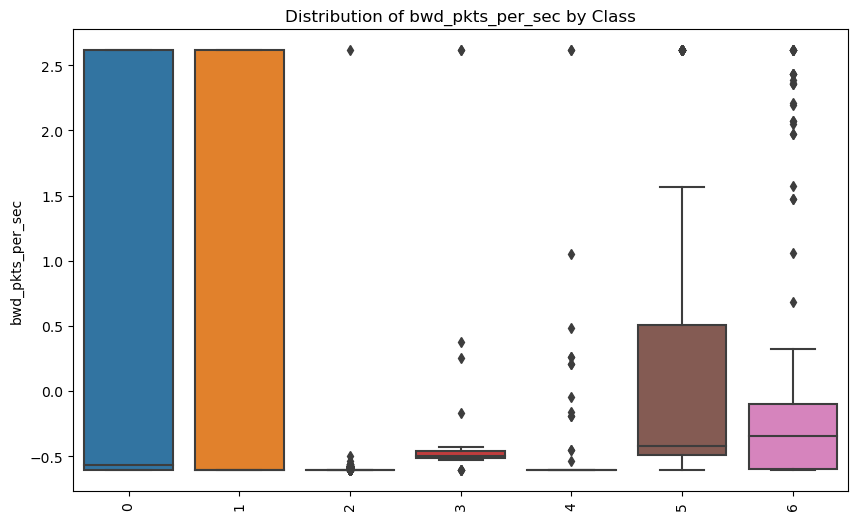

2   -0.604653
4   -0.526761
3   -0.286716
6   -0.046536
5   -0.005759
1    0.288958
0    0.347528
Name: bwd_pkts_per_sec, dtype: float64


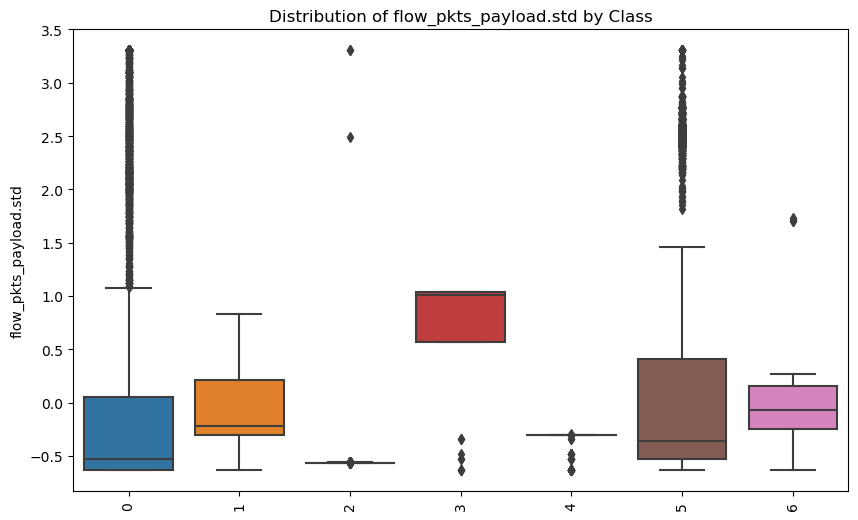

2   -0.558957
4   -0.367772
6   -0.042723
1   -0.008575
0    0.089146
5    0.217190
3    0.634079
Name: flow_pkts_payload.std, dtype: float64


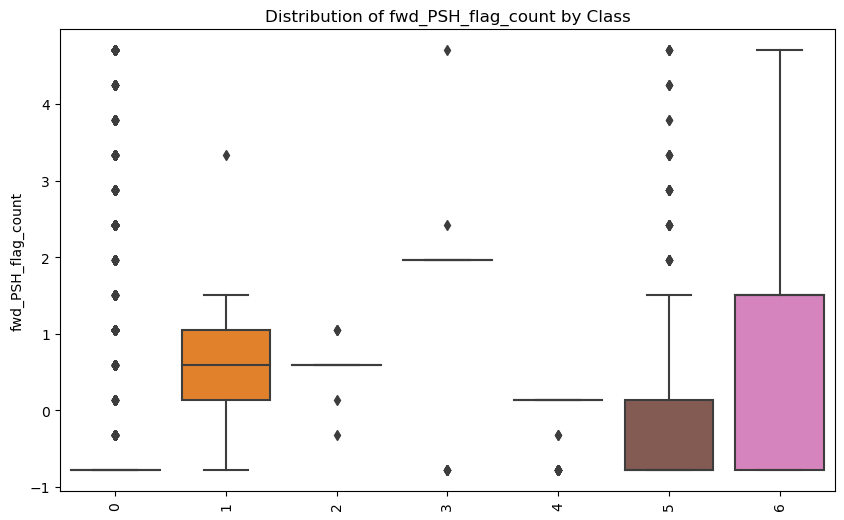

5   -0.272225
0   -0.123366
4   -0.078662
1    0.581499
2    0.587556
6    1.362982
3    1.451976
Name: fwd_PSH_flag_count, dtype: float64


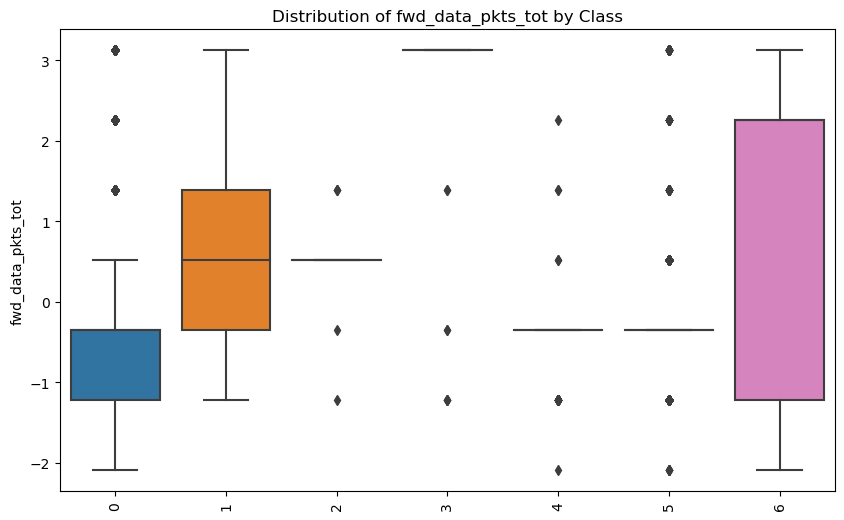

4   -0.472429
5   -0.255376
0   -0.090664
2    0.513373
1    0.515019
6    1.416059
3    2.369347
Name: fwd_data_pkts_tot, dtype: float64


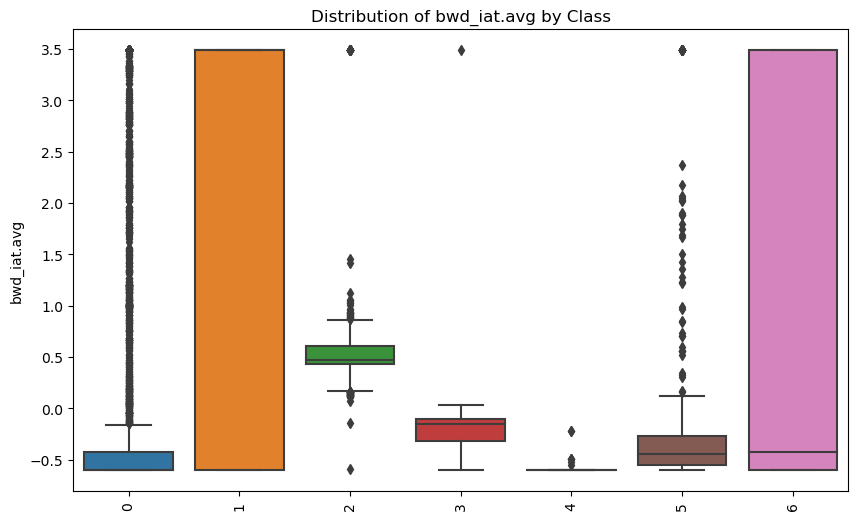

4   -0.597659
5   -0.387493
3   -0.155052
0    0.001260
2    0.536698
6    0.712523
1    1.558498
Name: bwd_iat.avg, dtype: float64


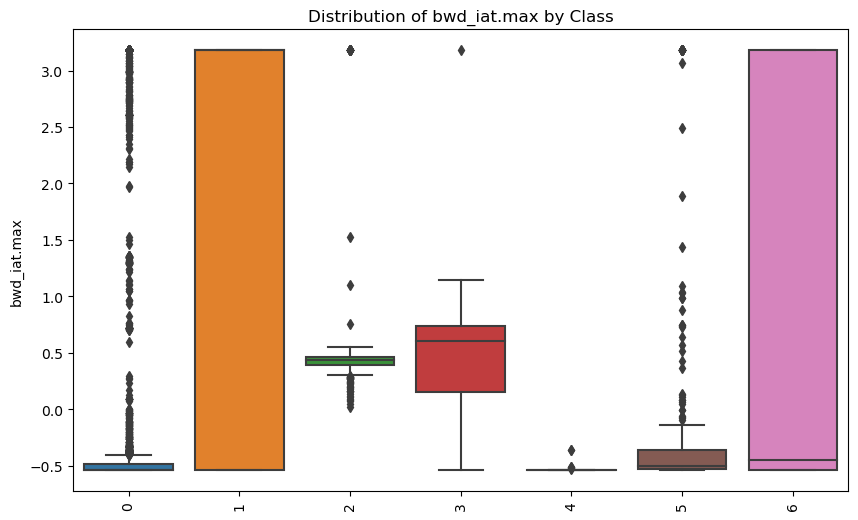

4   -0.540477
5   -0.426596
0    0.102769
3    0.416551
2    0.447801
6    0.650990
1    1.423983
Name: bwd_iat.max, dtype: float64


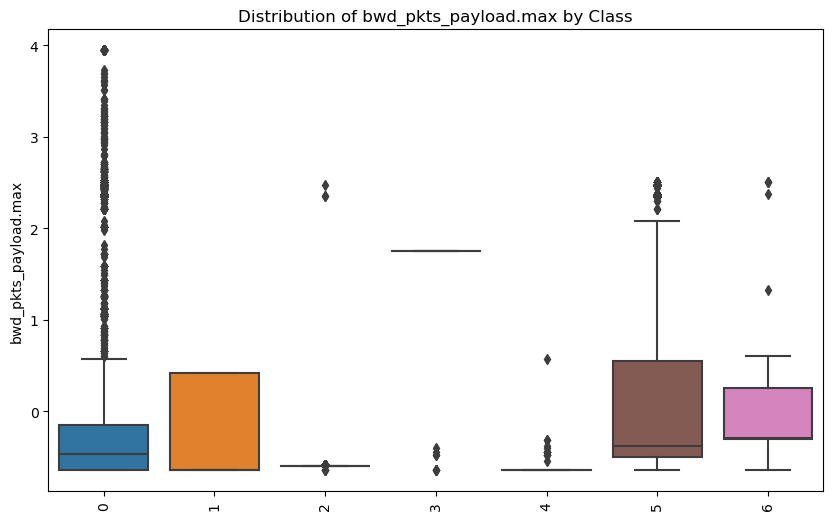

4   -0.620600
2   -0.592482
1   -0.341596
6   -0.013829
0    0.088017
5    0.260074
3    1.187037
Name: bwd_pkts_payload.max, dtype: float64


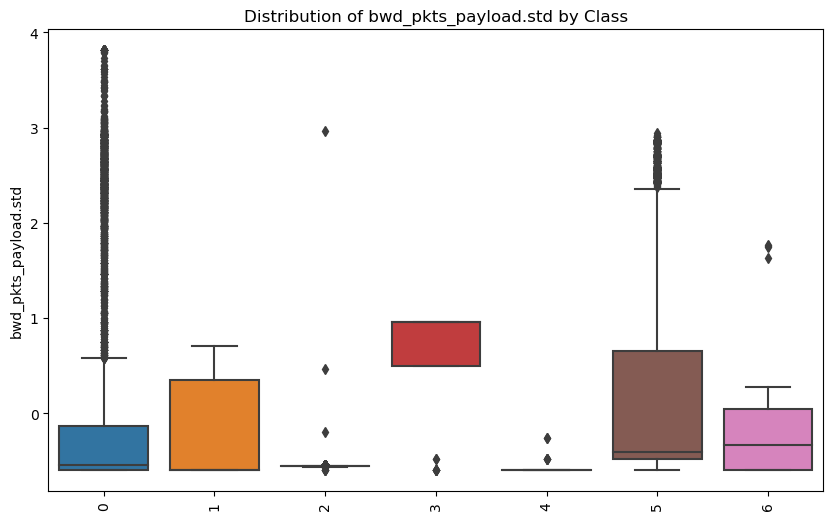

4   -0.595259
2   -0.555808
1   -0.254744
6   -0.228932
0    0.016746
5    0.307773
3    0.574353
Name: bwd_pkts_payload.std, dtype: float64


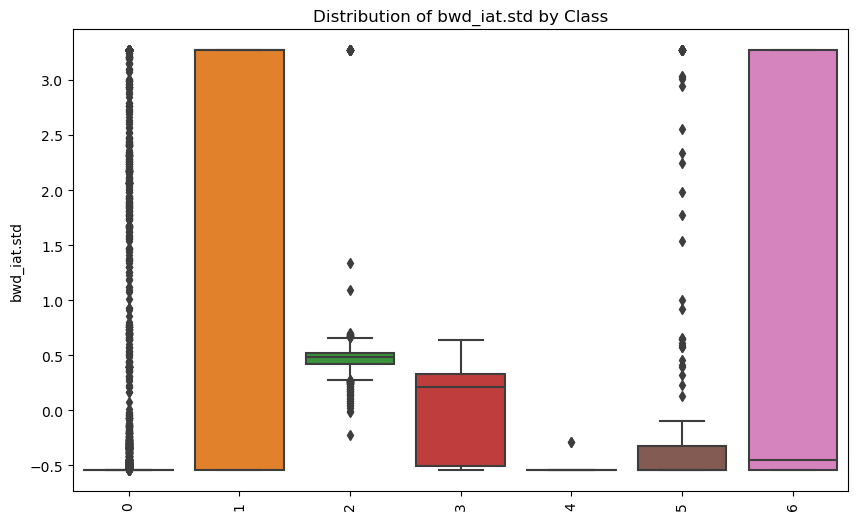

4   -0.544841
5   -0.423362
3    0.054920
0    0.071330
2    0.494574
6    0.638009
1    1.469678
Name: bwd_iat.std, dtype: float64


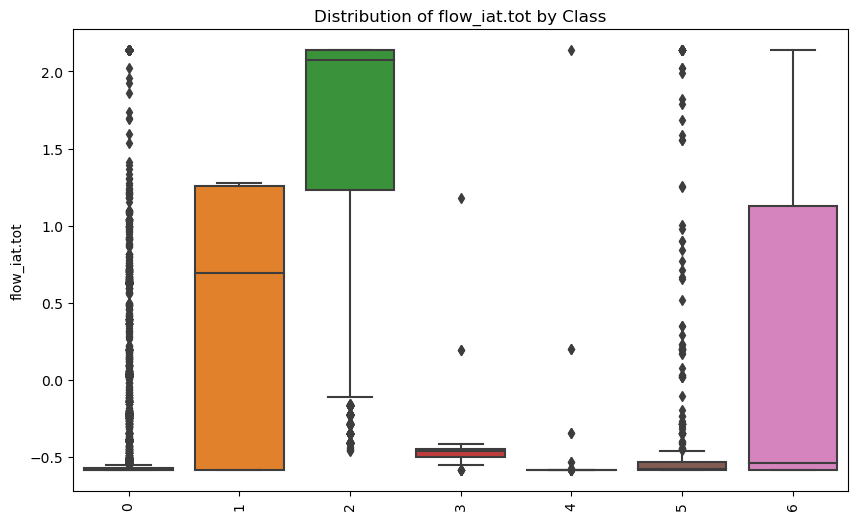

4   -0.560113
5   -0.543770
3   -0.405988
0   -0.299071
6    0.171445
1    0.307891
2    1.548446
Name: flow_iat.tot, dtype: float64


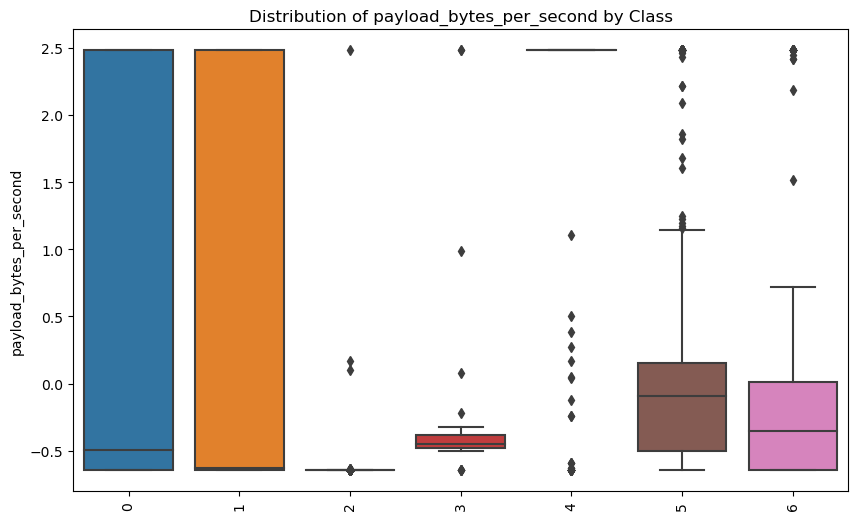

2   -0.643798
3   -0.247536
5   -0.103357
6    0.019777
0    0.382564
1    0.760653
4    1.829971
Name: payload_bytes_per_second, dtype: float64


In [36]:
X = pd.DataFrame(X, columns=features)  

for f in top_features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=y, y=X[f])  
    plt.title(f"Distribution of {f} by Class")
    plt.xticks(rotation=90)
    plt.show()

    
    print(X.groupby(y)[f].mean().sort_values())

In [37]:
import numpy as np

# Identify dominant features for specific classes
dominant_features = []

print("Features that disproportionately define certain classes:\n")

for feature in top_features:  
    class_means = X.groupby(y)[feature].mean()
    class_stds = X.groupby(y)[feature].std()
    overall_std = X[feature].std()


    ratio = class_stds / overall_std

    for cls in ratio.index:
        if ratio[cls] < 0.2:  
            if feature not in dominant_features:dominant_features.append(feature)
            print(f"Feature '{feature}' disproportionately defines Class {cls} (Variance Ratio: {ratio[cls]:.4f})")




Features that disproportionately define certain classes:

Feature 'fwd_pkts_payload.avg' disproportionately defines Class 2 (Variance Ratio: 0.0278)
Feature 'flow_pkts_payload.max' disproportionately defines Class 2 (Variance Ratio: 0.0798)
Feature 'flow_pkts_payload.max' disproportionately defines Class 4 (Variance Ratio: 0.1020)
Feature 'fwd_subflow_bytes' disproportionately defines Class 2 (Variance Ratio: 0.0225)
Feature 'flow_pkts_payload.avg' disproportionately defines Class 2 (Variance Ratio: 0.0885)
Feature 'fwd_last_window_size' disproportionately defines Class 2 (Variance Ratio: 0.1051)
Feature 'fwd_last_window_size' disproportionately defines Class 4 (Variance Ratio: 0.1681)
Feature 'fwd_pkts_payload.min' disproportionately defines Class 2 (Variance Ratio: 0.0000)
Feature 'fwd_iat.max' disproportionately defines Class 3 (Variance Ratio: 0.1931)
Feature 'fwd_iat.max' disproportionately defines Class 4 (Variance Ratio: 0.1845)
Feature 'fwd_iat.max' disproportionately defines C

In [38]:
X_train = pd.DataFrame(X_train, columns=features)  
X_test = pd.DataFrame(X_test, columns=features)

X_train_reduced = X_train.drop(columns=dominant_features)
X_test_reduced = X_test.drop(columns=dominant_features)

In [39]:
from sklearn.decomposition import PCA

train_index = X_train_reduced.index
test_index = X_test_reduced.index

pca = PCA(n_components=0.95)
print("Original number of features:", X_train_reduced.shape[1])

pca.fit(X_train_reduced)


X_train_reduced = pca.transform(X_train_reduced)
X_test_reduced = pca.transform(X_test_reduced)

pca_features = [f'PC{i+1}' for i in range(X_train_reduced.shape[1])]

X_train_reduced = pd.DataFrame(X_train_reduced, columns=pca_features, index=train_index)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=pca_features, index=test_index)

print("Shape of X_train after PCA:", X_train_reduced.shape)
print("Shape of X_test after PCA:", X_test_reduced.shape)

Original number of features: 56
Shape of X_train after PCA: (16198, 11)
Shape of X_test after PCA: (4050, 11)


Logistic Regression (After Removing Features and PCA) Classification Report:
Accuracy: 0.922716049382716
Precision (macro): 0.6484148454542006
Recall (macro): 0.48439546087616697
F1-score (macro): 0.5000718292216785


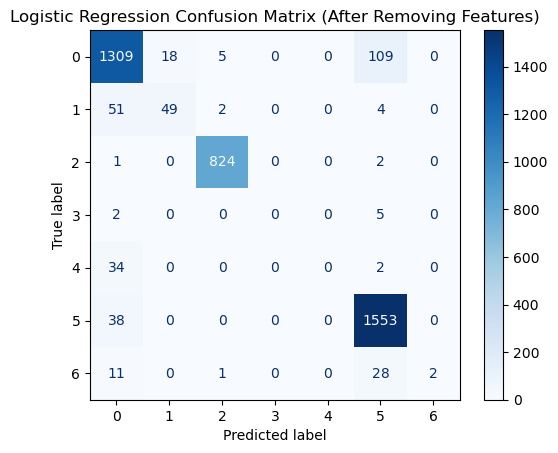

In [40]:
lr_model_removed_features = LogisticRegressionScratch(lr=0.01, n_iter=3000)
lr_model_removed_features.fit(X_train_reduced.values, y_train)
y_pred_lr_removed = lr_model_removed_features.predict(X_test_reduced.values)


print("Logistic Regression (After Removing Features and PCA) Classification Report:")

lr_removed_cm = confusion_matrix_scratch(y_test, y_pred_lr_removed)
lr_removed_acc, lr_removed_prec, lr_removed_rec, lr_removed_f1 = classification_report_scratch(y_test, y_pred_lr_removed, average='macro')
print("Accuracy:", lr_removed_acc)
print("Precision (macro):", lr_removed_prec)
print("Recall (macro):", lr_removed_rec)
print("F1-score (macro):", lr_removed_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=lr_removed_cm)
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix (After Removing Features)")
plt.show()

K-NN (After Removing Features and PCA) Classification Report:
Accuracy: 0.9829629629629629
Precision (macro): 0.9821914090395945
Recall (macro): 0.8700800098306383
F1-score (macro): 0.9082831474267462


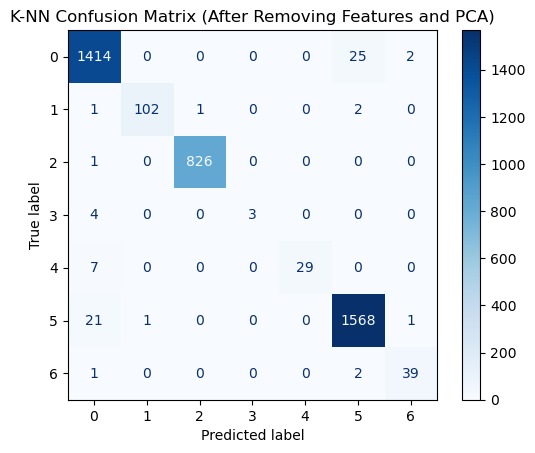

In [41]:
knn_model_removed_features = KNNClassifierScratch(k=5)
knn_model_removed_features.fit(X_train_reduced.values, y_train)
y_pred_knn_removed = knn_model_removed_features.predict(X_test_reduced.values)

knn_removed_cm = confusion_matrix_scratch(y_test, y_pred_knn_removed)
knn_removed_acc, knn_removed_prec, knn_removed_rec, knn_removed_f1 = classification_report_scratch(y_test, y_pred_knn_removed, average='macro')


print("K-NN (After Removing Features and PCA) Classification Report:")
print("Accuracy:", knn_removed_acc)
print("Precision (macro):", knn_removed_prec)
print("Recall (macro):", knn_removed_rec)
print("F1-score (macro):", knn_removed_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_removed_cm)
disp.plot(cmap='Blues')
plt.title("K-NN Confusion Matrix (After Removing Features and PCA)")
plt.show()





Decision Tree (After Removing Features and PCA) Classification Report:
Accuracy: 0.9733333333333334
Precision (macro): 0.8707413394022421
Recall (macro): 0.8409045569677362
F1-score (macro): 0.8546492121067034


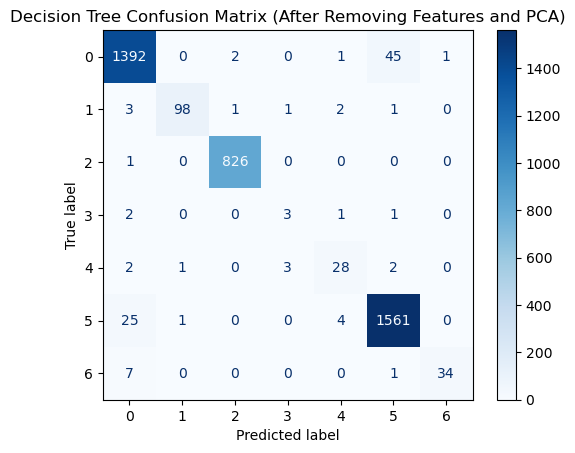

In [42]:
dt_model_removed_features = DecisionTreeScratch(max_depth=10, min_samples_split=5)
dt_model_removed_features.fit(X_train_reduced.values, y_train)
y_pred_dt_removed = dt_model_removed_features.predict(X_test_reduced.values)



dt_removed_cm = confusion_matrix_scratch(y_test, y_pred_dt_removed)
dt_removed_acc, dt_removed_prec, dt_removed_rec, dt_removed_f1 = classification_report_scratch(y_test, y_pred_dt_removed, average='macro')

print("Decision Tree (After Removing Features and PCA) Classification Report:")
print("Accuracy:", dt_removed_acc)
print("Precision (macro):", dt_removed_prec)
print("Recall (macro):", dt_removed_rec)
print("F1-score (macro):", dt_removed_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_removed_cm)
disp.plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix (After Removing Features and PCA)")
plt.show()

# Part 4: Implementing Clustering Algorithms

In [43]:
class KMeansScratch:
    def __init__(self, k=3, max_iter=100, random_state=42):
        self.k = k
        self.max_iter = max_iter
        np.random.seed(random_state)
        
    def fit(self, X):
        idx = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[idx, :]
        for _ in range(self.max_iter):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)
            new_centroids = []
            for i in range(self.k):
                if np.any(labels == i):
                    new_centroids.append(X[labels == i].mean(axis=0))
                else:
                    new_centroids.append(X[np.random.choice(len(X))])
            new_centroids = np.array(new_centroids)
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
        self.labels_ = labels

    def predict(self, X):
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

In [44]:
class DBSCANScratch:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def _region_query(self, X, idx):
        distances = np.sqrt(((X - X[idx])**2).sum(axis=1))
        return np.where(distances <= self.eps)[0]

    def fit(self, X):
        labels = np.full(X.shape[0], -1)
        cluster_id = 0
        visited = np.zeros(X.shape[0], dtype=bool)

        for i in range(X.shape[0]):
            if visited[i]:
                continue
            visited[i] = True
            neighbors = self._region_query(X, i)
            if len(neighbors) < self.min_samples:
                labels[i] = -1 
            else:
                labels[i] = cluster_id
                seed = list(neighbors)
                seed = [pt for pt in seed if pt != i]
                while seed:
                    current_point = seed.pop()
                    if not visited[current_point]:
                        visited[current_point] = True
                        neighbors2 = self._region_query(X, current_point)
                        if len(neighbors2) >= self.min_samples:
                            seed.extend(n for n in neighbors2 if labels[n] == -1)
                    if labels[current_point] == -1:
                        labels[current_point] = cluster_id
                cluster_id += 1
        self.labels_ = labels


In [45]:
def evaluate_clustering(X_data, clusterer, name):
    clusterer.fit(X_data)
    labels = clusterer.labels_

    unique_labels = np.unique(labels)
    if len(unique_labels) > 1 and len(unique_labels) != 1:
        sil = silhouette_score(X_data, labels)
    else:
        sil = -1  

    print(f"{name} - Number of clusters: {len(unique_labels)}, Silhouette: {sil:.4f}")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set2', legend='full')
    plt.title(f"{name} Clusters (PCA 2D projection)")
    plt.show()


In [46]:
def evaluate_clustering_Agglomerative(X_data, labels, name):
    unique_labels = np.unique(labels)

    if len(unique_labels) > 1:
        sil = silhouette_score(X_data, labels)
    else:
        sil = -1  
    
    print(f"{name}: Clusters: {len(unique_labels)}, Silhouette: {sil:.4f}")


    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set2', legend='full')
    plt.title(f"{name} (PCA 2D)")
    plt.show()

### With Standart Scaler

K-Means (All Features) with Standart Scaler - Number of clusters: 6, Silhouette: 0.4938


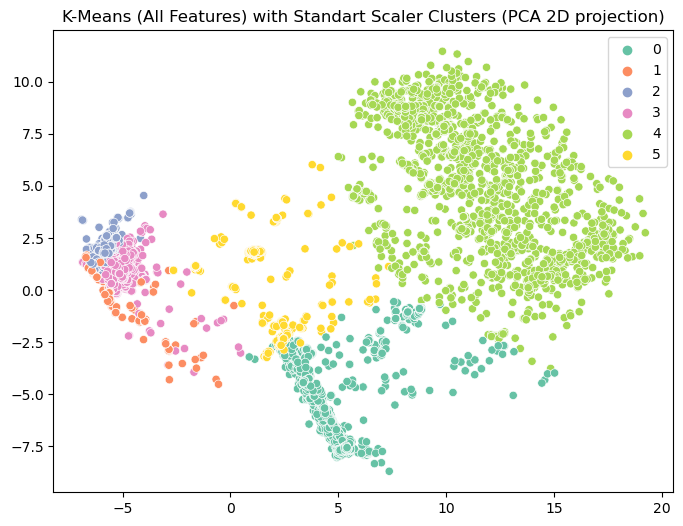

In [47]:
kmeans_all = KMeansScratch(k=6)
evaluate_clustering(X.values, kmeans_all, "K-Means (All Features) with Standart Scaler")

DBSCAN (All Features) with Standart Scaler - Number of clusters: 85, Silhouette: 0.4404


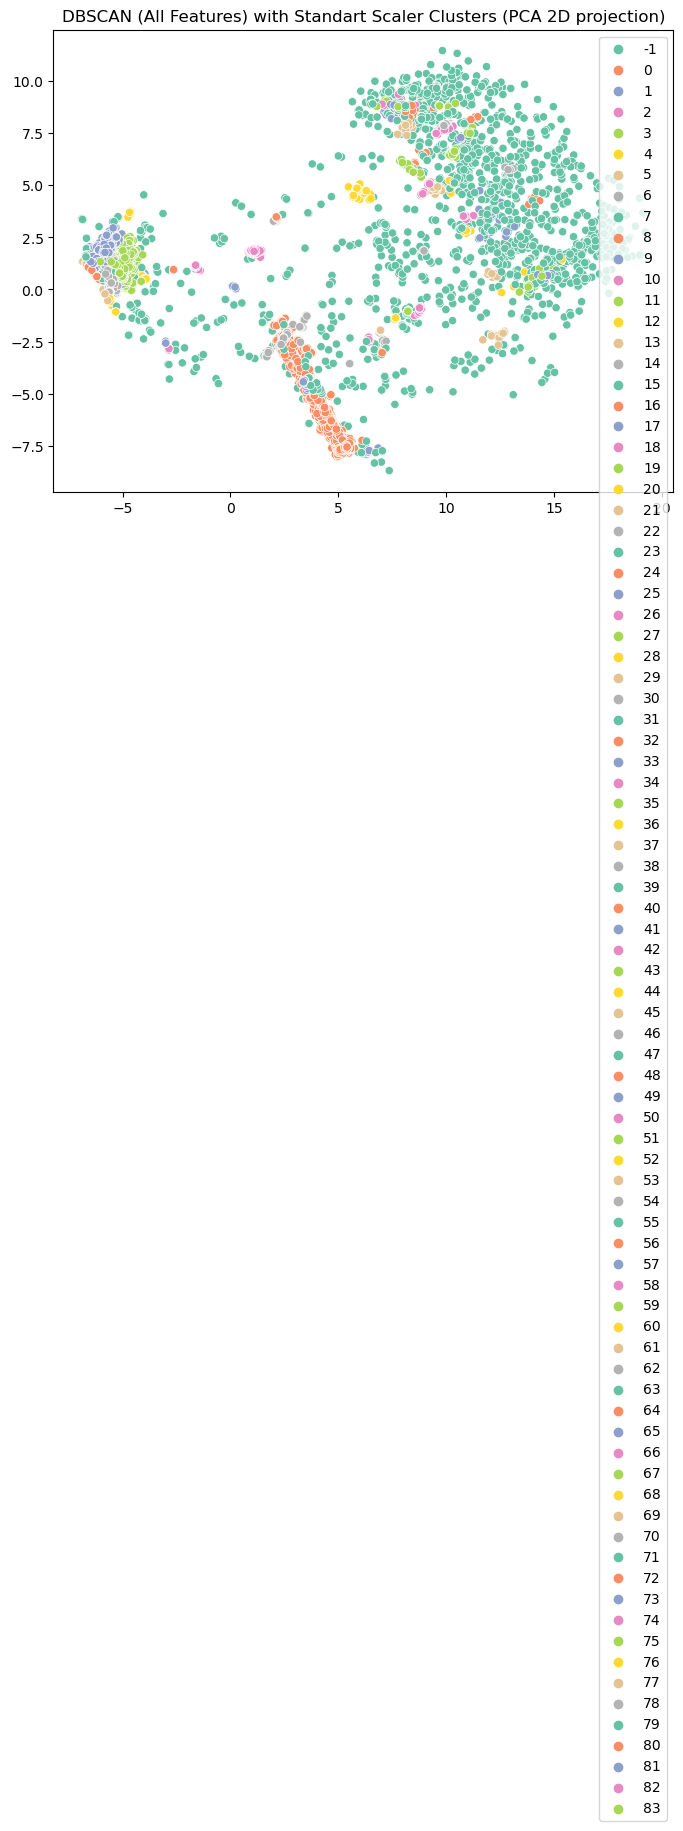

In [77]:
dbscan_all = DBSCANScratch(eps=1.6, min_samples=5)
evaluate_clustering(X.values, dbscan_all, "DBSCAN (All Features) with Standart Scaler")

Agglomerative Clustering (All Features) with Standart Scaler: Clusters: 3, Silhouette: 0.4841


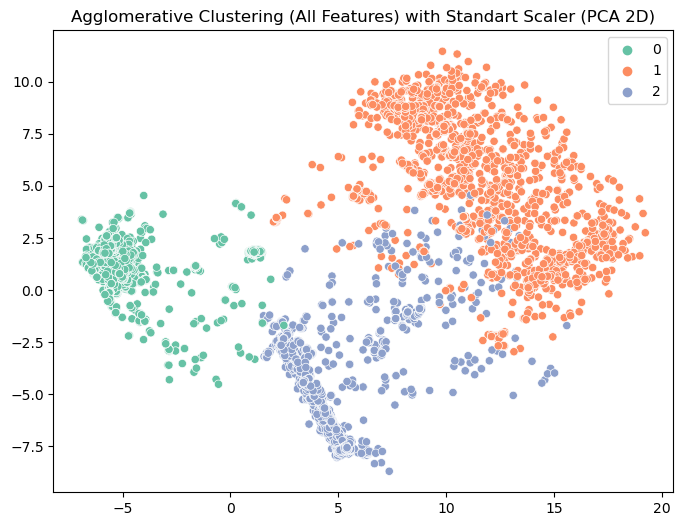

In [49]:
agg_all = AgglomerativeClustering(n_clusters=3)
labels_agg_all = agg_all.fit_predict(X.values)
evaluate_clustering_Agglomerative(X.values, labels_agg_all, "Agglomerative Clustering (All Features) with Standart Scaler")

### With Min-Max Scaler

In [50]:
X_minmax = df[features].values

In [51]:
scaler = MinMaxScaler()
Xscaledminmax = scaler.fit_transform(X_minmax)

K-Means (All Features) with Min-Max Sclaler - Number of clusters: 6, Silhouette: 0.4664


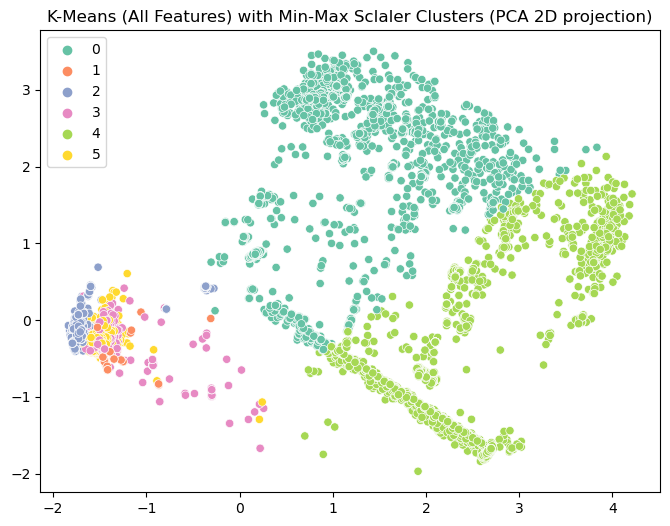

In [52]:
kmeans_all = KMeansScratch(k=6)
evaluate_clustering(Xscaledminmax, kmeans_all, "K-Means (All Features) with Min-Max Sclaler")

DBSCAN (All Features) with Min-Max Sclaler - Number of clusters: 85, Silhouette: 0.4404


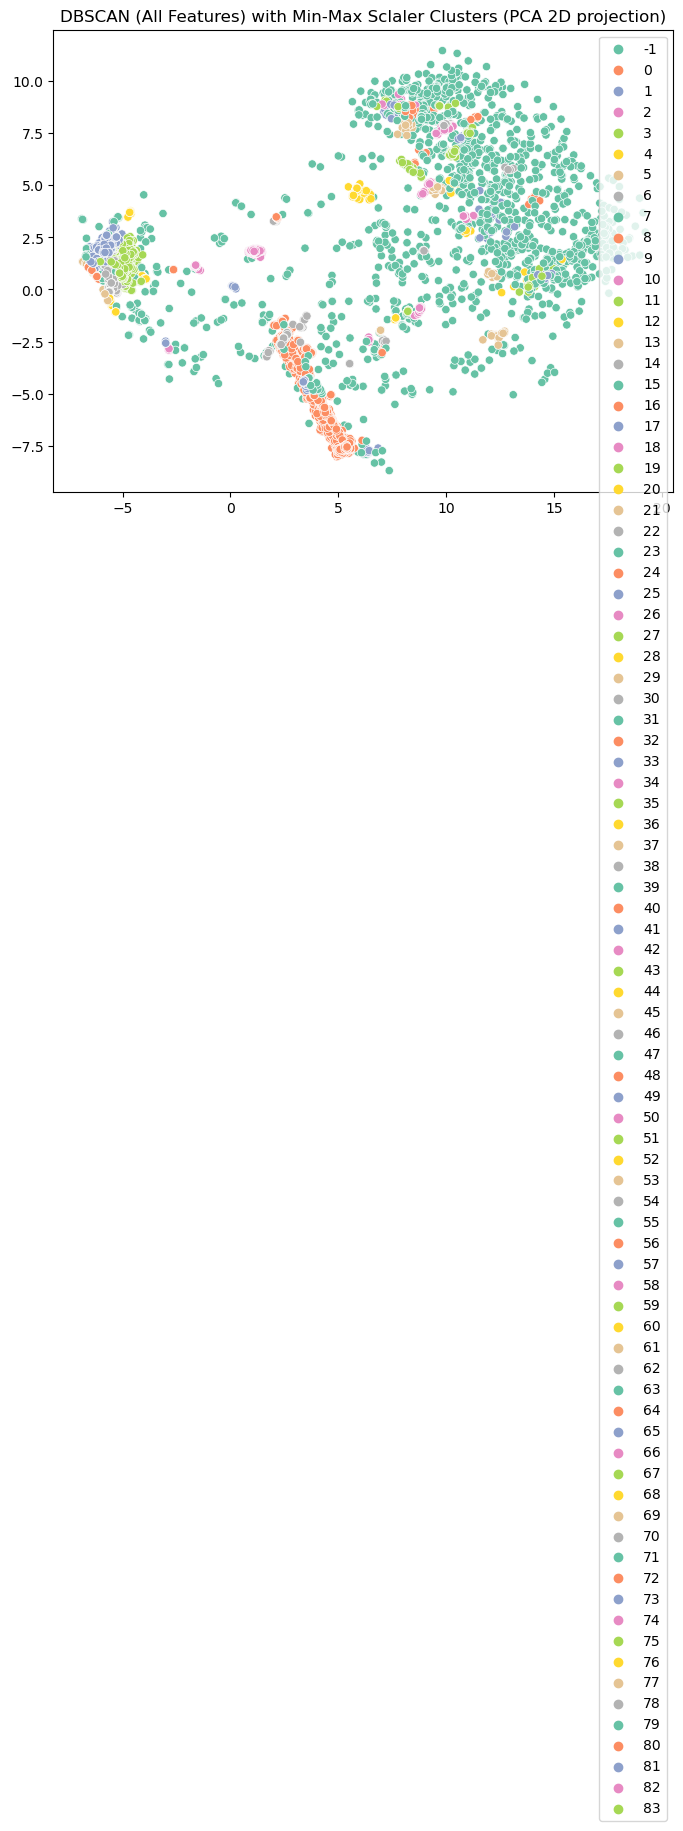

In [53]:
dbscan_all = DBSCANScratch(eps=1.6, min_samples=5)
evaluate_clustering(X_minmax, dbscan_all, "DBSCAN (All Features) with Min-Max Sclaler")

Agglomerative Clustering (All Features) with Min-Max Sclaler: Clusters: 3, Silhouette: 0.4841


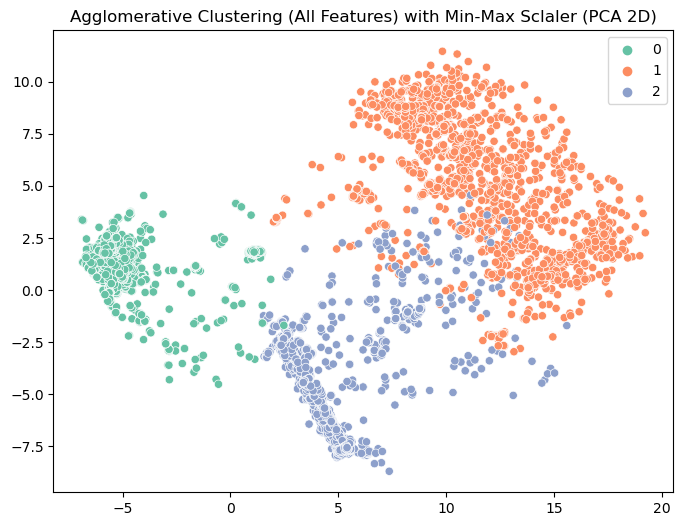

In [54]:
agg_all = AgglomerativeClustering(n_clusters=3)
labels_agg_all = agg_all.fit_predict(X_minmax)
evaluate_clustering_Agglomerative(X_minmax, labels_agg_all, "Agglomerative Clustering (All Features) with Min-Max Sclaler")

## Further Preprocessing

### PCA, Feature Reduction With Standart Scaler

In [55]:
dominant_features

['fwd_pkts_payload.avg',
 'flow_pkts_payload.max',
 'fwd_subflow_bytes',
 'flow_pkts_payload.avg',
 'fwd_last_window_size',
 'fwd_pkts_payload.min',
 'fwd_iat.max',
 'flow_pkts_payload.min',
 'fwd_iat.tot',
 'flow_iat.max',
 'flow_iat.avg',
 'fwd_iat.avg',
 'flow_duration',
 'flow_pkts_payload.tot',
 'id.resp_p',
 'fwd_pkts_payload.max',
 'bwd_pkts_per_sec',
 'flow_pkts_payload.std',
 'fwd_PSH_flag_count',
 'fwd_data_pkts_tot',
 'bwd_iat.avg',
 'bwd_iat.max',
 'bwd_pkts_payload.max',
 'bwd_pkts_payload.std',
 'bwd_iat.std',
 'flow_iat.tot',
 'payload_bytes_per_second']

In [56]:
features_reduced = [f for f in features if f not in dominant_features]

In [57]:
df_cluster

id.orig_p  id.resp_p  proto  service  flow_duration  fwd_pkts_tot  \
0        38667.0     1883.0      0        4      32.011598           9.0   
1        51143.0     1883.0      0        4      31.883584           9.0   
2        44761.0     1883.0      0        4      32.124053           9.0   
3        60893.0     1883.0      0        4      31.961063           9.0   
4        51087.0     1883.0      0        4      31.902362           9.0   
...          ...        ...    ...      ...            ...           ...   
26094    42902.0       53.0      1        1       0.020509           1.0   
26167    64177.0       53.0      1        1       0.000000           1.0   
26270    64177.0     5353.0      1        1       0.000000           1.0   
26284    64181.0     5353.0      1        1       0.000000           1.0   
26296    64185.0     5353.0      1        1       0.000000           1.0   

       bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
0               5.0                3.0                3.0          0.281148   
1               5.0                3.0                3.0          0.282277   
2               5.0                3.0                3.0          0.280164   
3               5.0                3.0                3.0          0.281593   
4               5.0                3.0                3.0          0.282111   
...             ...                ...                ...               ...   
26094           1.0                1.0                1.0         48.759070   
26167           0.0                1.0                0.0          0.000000   
26270           0.0                1.0                0.0          0.000000   
26284           0.0                1.0                0.0          0.000000   
26296           0.0                1.0                0.0          0.000000   

       ...  active.std     idle.min     idle.max     idle.tot     idle.avg  \
0      ...         0.0  29729182.96  29729182.96  29729182.96  29729182.96   
1      ...         0.0  29855277.06  29855277.06  29855277.06  29855277.06   
2      ...         0.0  29842149.02  29842149.02  29842149.02  29842149.02   
3      ...         0.0  29913774.97  29913774.97  29913774.97  29913774.97   
4      ...         0.0  29814704.90  29814704.90  29814704.90  29814704.90   
...    ...         ...          ...          ...          ...          ...   
26094  ...         0.0         0.00         0.00         0.00         0.00   
26167  ...         0.0         0.00         0.00         0.00         0.00   
26270  ...         0.0         0.00         0.00         0.00         0.00   
26284  ...         0.0         0.00         0.00         0.00         0.00   
26296  ...         0.0         0.00         0.00         0.00         0.00   

       idle.std  fwd_init_window_size  bwd_init_window_size  \
0           0.0               64240.0               26847.0   
1           0.0               64240.0               26847.0   
2           0.0               64240.0               26847.0   
3           0.0               64240.0               26847.0   
4           0.0               64240.0               26847.0   
...         ...                   ...                   ...   
26094       0.0                   0.0                   0.0   
26167       0.0                   0.0                   0.0   
26270       0.0                   0.0                   0.0   
26284       0.0                   0.0                   0.0   
26296       0.0                   0.0                   0.0   

       fwd_last_window_size  Attack_type  
0                     502.0            2  
1                     502.0            2  
2                     502.0            2  
3                     502.0            2  
4                     502.0            2  
...                     ...          ...  
26094                   0.0            4  
26167                   0.0            4  
26270                   0.0            4  
26284                

In [58]:
X_reduced = df_cluster[features_reduced].values

In [59]:
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

### Clustering on Reduced Features###
K-Means (Standart Scaler + Reduced + PCA): Clusters: 6, Silhouette: 0.4425


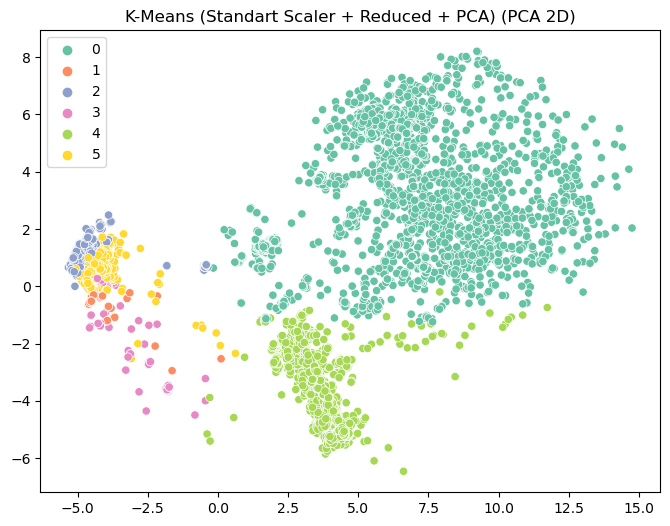

In [60]:
print("### Clustering on Reduced Features###")
pca = PCA(n_components=0.95)
X_reduced_pca = pca.fit_transform(X_reduced_scaled)

kmeans_reduced = KMeansScratch(k=6)
kmeans_reduced.fit(X_reduced_pca)
evaluate_clustering_Agglomerative(X_reduced_pca, kmeans_reduced.labels_, "K-Means (Standart Scaler + Reduced + PCA)")


DBSCAN (Standart Scaler + Reduced + PCA): Clusters: 53, Silhouette: 0.4082


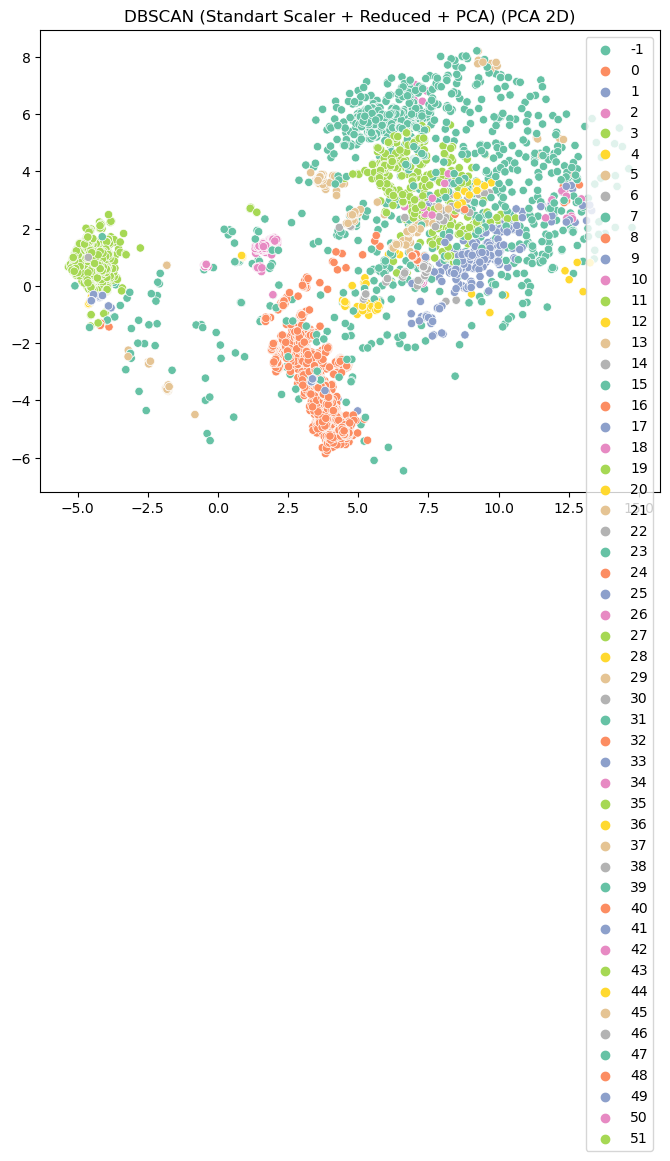

In [61]:
dbscan_reduced = DBSCANScratch(eps=1.6, min_samples=5)
dbscan_reduced.fit(X_reduced_pca)
evaluate_clustering_Agglomerative(X_reduced_pca, dbscan_reduced.labels_, "DBSCAN (Standart Scaler + Reduced + PCA)")

Agglomerative (Standart Scaler + Reduced + PCA): Clusters: 3, Silhouette: 0.4605


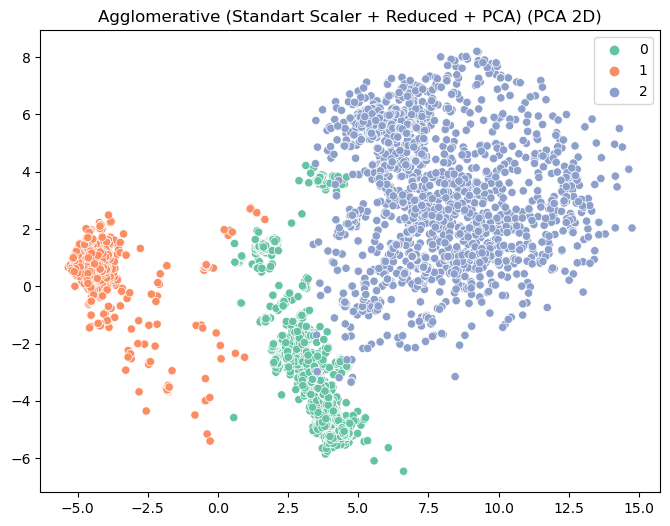

In [62]:
agg_reduced = AgglomerativeClustering(n_clusters=3)
labels_agg_reduced = agg_reduced.fit_predict(X_reduced_pca)
evaluate_clustering_Agglomerative(X_reduced_pca, labels_agg_reduced, "Agglomerative (Standart Scaler + Reduced + PCA)")

### PCA, Feature Reduction With Min-Max Scaler

In [63]:
X_reduced_minmax = df_cluster[features_reduced].values

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_reduced_scaledminmax = scaler.fit_transform(X_reduced_minmax)

In [65]:
pca = PCA(n_components=0.95)
X_reduced_pca_minmax = pca.fit_transform(X_reduced_scaledminmax)

### Clustering on Reduced Features with Min-Max Scaler###
K-Means (Min-Max Scaler + Reduced + PCA): Clusters: 6, Silhouette: 0.5465


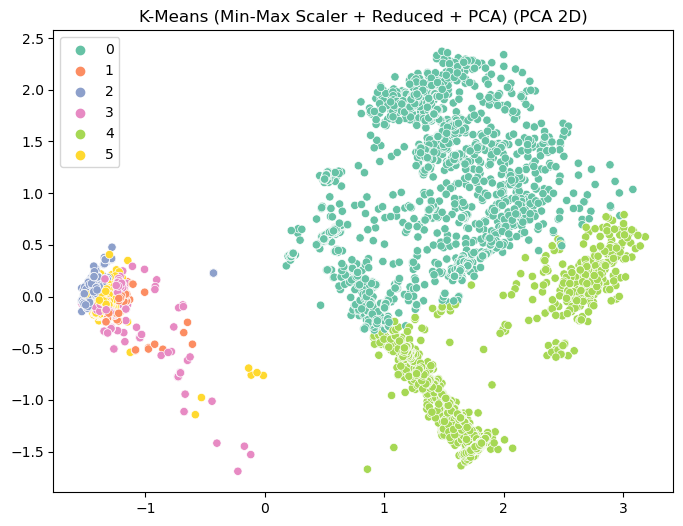

In [66]:
print("### Clustering on Reduced Features with Min-Max Scaler###")
kmeans_reduced_minmax = KMeansScratch(k=6)
kmeans_reduced_minmax.fit(X_reduced_pca_minmax)
evaluate_clustering_Agglomerative(X_reduced_pca_minmax, kmeans_reduced_minmax.labels_, "K-Means (Min-Max Scaler + Reduced + PCA)")


DBSCAN (Min-Max Scaler + Reduced + PCA): Clusters: 4, Silhouette: 0.3313


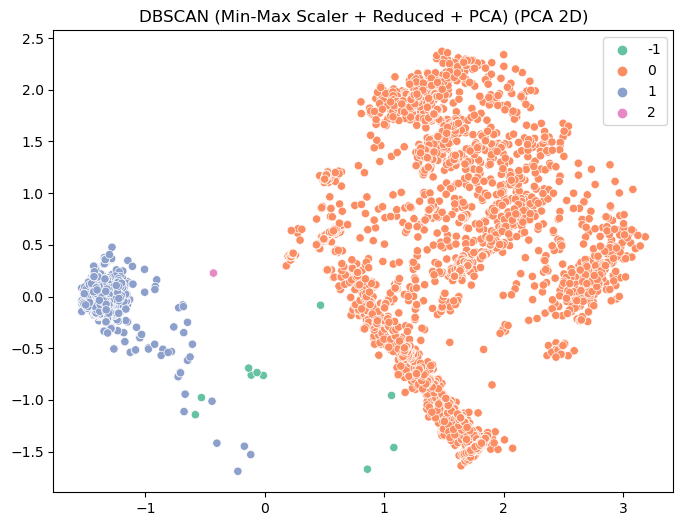

In [79]:
dbscan_reduced_minmax = DBSCANScratch(eps=1, min_samples=5)
dbscan_reduced_minmax.fit(X_reduced_pca_minmax)
evaluate_clustering_Agglomerative(X_reduced_pca_minmax, dbscan_reduced_minmax.labels_, "DBSCAN (Min-Max Scaler + Reduced + PCA)")

Agglomerative (Min-Max Scaler + Reduced + PCA): Clusters: 3, Silhouette: 0.5246


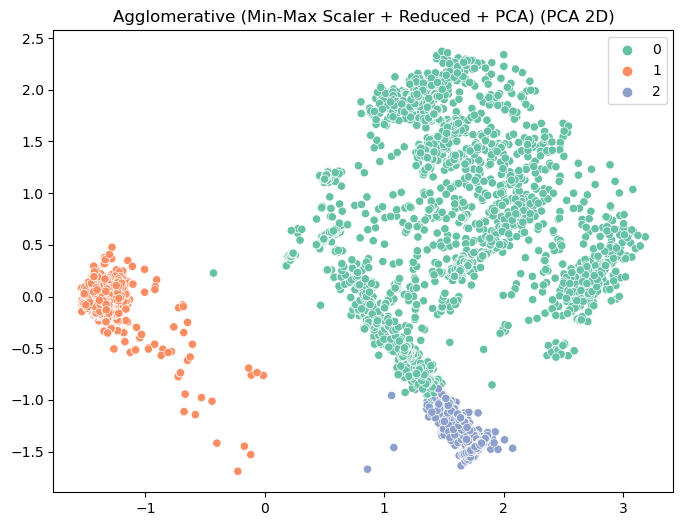

In [68]:
agg_reduced_minmax = AgglomerativeClustering(n_clusters=3)
labels_agg_reduced_minmax = agg_reduced_minmax.fit_predict(X_reduced_pca_minmax)
evaluate_clustering_Agglomerative(X_reduced_pca_minmax, labels_agg_reduced_minmax, "Agglomerative (Min-Max Scaler + Reduced + PCA)")

# Part 5: Comparison and Analysis

## Comparison and Analysis of Classification Algorithms

# 📊 Classification Algorithm Results

| **Model**                       | **Accuracy** | **Precision (Macro)** | **Recall (Macro)** | **F1-score (Macro)** |
|---------------------------------|--------------|------------------------|--------------------|-----------------------|
| 🔹 Logistic Regression (Original) | 0.9531       | 0.7439                 | 0.7085             | 0.7175                |
| 🔹 K-NN (Original)               | 0.9842       | 0.9848                 | 0.8739             | 0.9115                |
| 🔹 Decision Tree (Original)      | 0.9869       | 0.9826                 | 0.8860             | 0.9178                |
| 🔸 Logistic Regression (After)   | 0.9227       | 0.6484                 | 0.4844             | 0.5001                |
| 🔸 K-NN (After)                  | 0.9830       | 0.9822                 | 0.8701             | 0.9083                |
| 🔸 Decision Tree (After)         | 0.9733       | 0.8707                 | 0.8409             | 0.8546                |

---

- 🔹 **Original**: Results before removing obvious features.
- 🔸 **After**: Results after removing obvious features and applying PCA.



## Algorithms Considered:
- Logistic Regression
- K-Nearest Neighbors (K-NN)
- Decision Tree

## We have two sets of results:
1. **Before Removing Obvious Features** (original high-dimensional feature set)
2. **After Removing Obvious Features and Applying PCA** (reduced, transformed feature space)


---

## Before Removing Obvious Features

### Logistic Regression (Original):
- **Accuracy**: 0.9531  
- **Precision (macro)**: 0.7439  
- **Recall (macro)**: 0.7085  
- **F1-score (macro)**: 0.7175  

**Interpretation**:  
Logistic Regression performed well with a high accuracy (~95%) but the macro precision, recall, and F1 suggest that while it classifies some classes very well, it may struggle with certain minority classes. The precision and recall are balanced but not extremely high, indicating that while the classifier is quite good, it might rely heavily on certain distinctive features.

---

### K-NN (Original):
- **Accuracy**: 0.9842  
- **Precision (macro)**: 0.9848  
- **Recall (macro)**: 0.8739  
- **F1-score (macro)**: 0.9115  

**Interpretation**:  
K-NN shows excellent performance, with very high accuracy (98%), precision, and relatively high recall. This suggests K-NN is leveraging the full feature set effectively, potentially relying on some "giveaway" features for near-perfect discrimination of certain classes. The high macro F1 (0.91) suggests it is consistently performing well across all classes, not just the dominant ones.

---

### Decision Tree (Original):
- **Accuracy**: 0.9869  
- **Precision (macro)**: 0.9826  
- **Recall (macro)**: 0.8860  
- **F1-score (macro)**: 0.9178  

**Interpretation**:  
Decision Tree also performs exceptionally, with very high accuracy (~98.7%). The high precision and recall indicate its ability to handle class distinctions well. The inherent feature selection ability of decision trees allows for effective classification.

---

### Summary of Before-Feature-Removal Results:
- K-NN and Decision Tree outperform Logistic Regression in overall metrics.
- Very high accuracy and F1 scores for K-NN and Decision Tree suggest some classes are trivially separable using specific features.
- Logistic Regression’s slightly lower performance stems from its linear decision boundary limitations.

---

## Identification of Obvious Features
The analysis revealed several features disproportionately defining certain classes. These "obvious" features allowed the models, especially tree-based and nearest-neighbor methods, to excel without necessarily learning more subtle distinctions. Removing or transforming these features is intended to evaluate how robust the models are and whether they can still maintain good performance.





---

## After Removing Obvious Features and Applying PCA

### Logistic Regression (After):
- **Accuracy**: 0.9227  
- **Precision (macro)**: 0.6484  
- **Recall (macro)**: 0.4844  
- **F1-score (macro)**: 0.5001  

**Interpretation**:  
Logistic Regression’s performance drops significantly after removing discriminative features and dimensionality reduction. Accuracy, recall, and F1-score decrease, indicating heavy reliance on discriminative features for class separation.

---

### K-NN (After):
- **Accuracy**: 0.9830  
- **Precision (macro)**: 0.9822  
- **Recall (macro)**: 0.8701  
- **F1-score (macro)**: 0.9083  

**Interpretation**:  
K-NN remains stable despite feature removal and PCA. Its robustness to transformations ensures high performance in reduced-dimensional space, leveraging informative patterns effectively.

---

### Decision Tree (After):
- **Accuracy**: 0.9733  
- **Precision (macro)**: 0.8707  
- **Recall (macro)**: 0.8409  
- **F1-score (macro)**: 0.8546  

**Interpretation**:  
Decision Tree’s performance drops slightly but remains strong. Its ability to adapt to the reduced feature space confirms its robustness, though it relied on obvious features earlier.

---

## Comparison of Before and After Results

### Logistic Regression:
- Significant performance drop when obvious features are removed and PCA is applied. This indicates that LR’s linear decision boundary was heavily dependent on those discriminative features for class separation. Without them, LR struggles, suggesting it may need more nuanced features or additional transformations to recover performance.

### K-NN:
- Remains consistently high-performing even after feature removal and PCA. This robustness points to K-NN’s flexibility in utilizing distance metrics in lower-dimensional, normalized feature spaces. K-NN remains a strong candidate.

### Decision Tree:
- Performance decreases slightly after removing obvious features but remains strong.
- Still a good balance between interpretability and performance.

---



## Strengths and Weaknesses of Each Algorithm

### Logistic Regression:
- **Strengths**: 
    - Logistic Regression achieved a solid accuracy of 95.3% on the original dataset. This indicates that the majority of the classes are linearly separable in the feature space.
    - Despite its simplicity, it performed well on the dominant classes (Classes 0, 2, and 5), with high true positives for these categories.
    - Features such as fwd_iat.min, flow_iat.min, and fwd_pkts_payload.avg were critical in separating these classes effectively.

- **Weaknesses**: 
    - **Poor Recall for Minority Classes:** The recall scores for underrepresented classes (e.g., Class 3 and Class 4) were particularly low. For example, Class 3 had no correct predictions, as shown in the confusion matrix, and Class 4 had a very low recall. 
    - **Feature Sensitivity:** After feature removal and PCA, Logistic Regression's performance dropped significantly (accuracy: 92.3%, macro F1-score: 0.50), indicating that certain features disproportionately influenced classification.
    - Linear assumptions limited its ability to model complex, non-linear patterns that are present in this dataset.

### K-NN:
- **Strengths**: 
    - K-NN outperformed other algorithms with an accuracy of 98.4% and a macro F1-score of 0.91. This demonstrates its ability to handle the non-linear structure of the dataset effectively.
    - K-NN performed exceptionally well across all major classes (Classes 0, 2, and 5), achieving nearly perfect recall and precision for these classes.
    - **Robustness to Feature Removal:** After removing features and applying PCA, K-NN still maintained a high accuracy of 98.3% and macro F1-score of 0.91, showing that it effectively adapts to reduced feature space
- **Weaknesses**: 
    - **Computational Cost:** Given the dataset size, K-NN likely incurred significant computation during the distance calculations.

### Decision Tree:
- **Strengths**: Handles non-linear boundaries well, naturally selects important features.  
- **Weaknesses**: Can overfit if not tuned properly; performance drops slightly after removing obvious features.

---

## Why Does One Algorithm Outperform the Others?
- **Decision Tree** and **K-NN** outperform Logistic Regression because they can handle **non-linear relationships** and **complex decision boundaries** in the dataset.
- **Decision Tree** provides better performance for balanced classes due to its hierarchical splitting of features.
- **K-NN performs** well because it is a distance-based algorithm that thrives when relationships between classes are clearly separable in feature space.
---

## Conclusions and Recommendations
- **Before feature removal**: K-NN and Decision Tree excel due to reliance on obvious features.
- **After removing obvious features and PCA**: K-NN remains highly effective, and Decision Tree still provides strong performance. Logistic Regression’s performance suffers significantly, indicating it needs more discriminative or well-engineered features.

### Final Choice:
- Given these findings, K-NN seems to be the best suited for maintaining high performance across different data transformations, while Decision Trees offer a good compromise if you want some interpretability and don’t mind a slight performance drop. Logistic Regression might not be the best standalone model in this scenario without additional feature engineering or more complex transformations.









---
---
---
## Comparison and Analysis of Clustering Algorithms

### Clustering Algorithms Considered:
- **K-Means**
- **DBSCAN**
- **Agglomerative Clustering**

### Preprocessing Scenarios:
1. **All features, Standard Scaler**
2. **All features, Min-Max Scaler**
3. **Reduced features (after removing obvious ones), PCA, Standard Scaler**
4. **Reduced features, PCA, Min-Max Scaler**

For each scenario, the number of clusters identified and the silhouette score (a metric for cluster quality, where higher is better) were compared.

---

## Results Summary

# Clustering Results Summary

| **Scenario**                          | **Algorithm**   | **Clusters** | **Silhouette Score** |
|---------------------------------------|-----------------|--------------|-----------------------|
| **All Features + Standard Scaler**    | K-Means         | 6            | 0.4938               |
|                                       | DBSCAN          | 85           | 0.4404               |
|                                       | Agglomerative   | 3            | 0.4841               |
| **All Features + Min-Max Scaler**     | K-Means         | 6            | 0.4664               |
|                                       | DBSCAN          | 85           | 0.4404               |
|                                       | Agglomerative   | 3            | 0.4841               |
| **Reduced Features + PCA + Standard Scaler** | K-Means   | 6            | 0.4425               |
|                                       | DBSCAN          | 53           | 0.4082               |
|                                       | Agglomerative   | 3            | 0.4605               |
| **Reduced Features + PCA + Min-Max Scaler**  | K-Means   | 6            | **0.5465**           |
|                                       | DBSCAN          | 4            | 0.3313               |
|                                       | Agglomerative   | 3            | 0.5246               |


---

## Interpretation by Algorithm

### **K-Means:**
- With all features, **K-Means finds** 6 clusters and achieves a respectable silhouette (~0.49 with standard scaling).

- Switching to **Min-Max scaling** with all features slightly reduces the silhouette (0.4664), indicating K-Means might prefer the standardized data in this scenario.

- After **removing obvious features** and **applying PCA**, K-Means on **Standard Scaler** drops to 0.4425, slightly worse than with all features. This suggests the removed features and PCA transformation might have removed some discriminative structure K-Means was leveraging.

- However, using **Min-Max scaling** on the **reduced+PCA** data significantly improves the silhouette to 0.5465, which is the best K-Means result overall. This indicates that the combination of feature selection, dimensionality reduction, and an appropriate scaler can yield more well-defined clusters for K-Means.

---

### **DBSCAN:**
- With all features, **DBSCAN** finds a very large number of clusters (85) and a moderate silhouette (0.4404). This suggests DBSCAN is identifying many **small, dense regions as individual clusters—possibly due to parameter choices (eps, min_samples) or data structure**.
- Changing to **Min-Max scaling** doesn’t affect DBSCAN’s silhouette or cluster count with all features. It remains at 85 clusters and 0.4404 silhouette, indicating the data distribution still pushes DBSCAN to form many small clusters.
- After **removing features and applying PCA with Standard Scaler**, DBSCAN reduces the number of clusters to 53, but silhouette drops to 0.4082. DBSCAN still struggles to form a manageable number of cohesive clusters under these conditions.
- Using **Min-Max scaling on the reduced+PCA data**, DBSCAN finally identifies fewer clusters (4 clusters) but now has a much lower silhouette (0.3313). While the number of clusters is more reasonable, the overall cluster quality (as measured by silhouette) is poorer. DBSCAN may need parameter tuning or may not be well-suited to the data distribution even after feature engineering and scaling.

---

### **Agglomerative Clustering:**
- With **all features and Standard Scaling,** Agglomerative Clustering forms 3 clusters with a silhouette of 0.4841. This is a relatively good performance, close to K-Means.
- Changing to **Min-Max scaling** with all features doesn’t change the number of clusters or the silhouette score, indicating Agglomerative Clustering is relatively stable to this scaling change.
- After **removing features and applying PCA with Standard Scaler**, Agglomerative Clustering still forms 3 clusters, but silhouette slightly dips to 0.4605, suggesting a small performance loss due to removing these discriminative features.
- With **Min-Max scaling and the reduced+PCA data**, Agglomerative Clustering’s silhouette improves to 0.5246, a substantial gain. It remains at 3 clusters but now shows a higher silhouette, indicating more cohesive clusters in this transformed data space.

---

## Comparison and Analysis



### Impact of Removing Obvious Features and Applying PCA:
- For **K-Means** and **Agglomerative Clustering**, removing obviously discriminative features, applying PCA, and using Min-Max scaling improved the silhouette scores compared to most original scenarios. This suggests that a carefully chosen pipeline of feature selection and scaling can lead to more meaningful cluster structures.
- For **DBSCAN**, while the number of clusters became more manageable with the reduced+PCA data (4 clusters), the silhouette score worsened. This could indicate that DBSCAN’s parameters are not well-tuned for the new data representation or that DBSCAN isn’t as well-suited to this particular data distribution.

### Effect of Scaling:
- **Agglomerative Clustering** appears stable and even thrives under Min-Max scaling when combined with PCA and feature removal, producing a better silhouette score.
- **K-Means** benefits significantly from Min-Max scaling once the data is reduced and transformed by PCA.
- **DBSCAN’s** performance is relatively consistent (and not optimal) across scaling methods, suggesting other hyperparameters (`eps`, `min_samples`) might need tuning.

### Number of Clusters:
- **K-Means** consistently finds 6 clusters under all conditions. Adjusting `k` or initial parameters might be considered if fewer or more clusters are desired.
- **DBSCAN’s** number of clusters is highly sensitive to the data representation: from 85 clusters (very fragmented) down to 4 after PCA and feature removal. However, the silhouette score doesn’t necessarily improve, indicating these clusters aren’t very cohesive.
- **Agglomerative Clustering** remains stable at 3 clusters in all tested conditions, demonstrating a consistent structure in the data that is likely being preserved across transformations.

---
## Why Does One Algorithm Outperform the Others?

### K-Means:
- **Performance**:  
  K-Means performed the best overall in terms of Silhouette Scores across configurations. It works well on this dataset because the clusters are compact and spherical in nature.
- **Adaptability**:  
  Its performance improved significantly after PCA and Min-Max scaling, demonstrating adaptability to feature reduction.

---

### DBSCAN:
- **Performance Issues**:  
  DBSCAN struggled with this dataset, as indicated by its tendency to over-segment clusters (85 clusters with all features) or under-cluster (4 clusters after PCA). This reflects sensitivity to its `eps` and `min_samples` parameters.
- **Impact of Feature Transformation**:  
  The performance drop after PCA and feature removal suggests DBSCAN may not be ideal for datasets where class separability heavily depends on transformed or reduced features.

---

### Agglomerative Clustering:
- **Consistency**:  
  Agglomerative Clustering provided stable results (always 3 clusters) across all configurations, with consistent performance improvements after Min-Max scaling.
- **Effectiveness**:  
  Its reliance on hierarchical relationships makes it less adaptable to PCA but still effective for well-separated clusters.












---

## Strengths and Weaknesses

### **K-Means:**

#### Strengths:
- Identified 6 clusters consistently, achieving the highest Silhouette Score (0.5465) with Min-Max scaling and PCA.
- Handles high-dimensional data well, retaining performance after feature reduction and PCA.
- Computationally efficient for medium-sized datasets.

#### Weaknesses:
- Sensitive to feature scaling; performance dropped with the standard scaler.
- Assumes spherical clusters, which may not align perfectly with the dataset.
- Struggles with noise and outliers, leading to reduced cohesion.

### **DBSCAN:**

#### Strengths:
- Handles noise and outliers effectively, forming 85 clusters when all features were used.
- Does not require the number of clusters as an input.
- Identifies arbitrary-shaped clusters, making it suitable for non-linear patterns.

#### Weaknesses:
- Over-segmentation with all features (85 clusters) and under-segmentation after PCA (4 clusters).
- Highly sensitive to `eps` and `min_samples`, making parameter tuning critical.
- Struggles with high-dimensional data, resulting in low cohesion after PCA.

### **Agglomerative Clustering:**

#### Strengths:
- Consistently identified 3 clusters across configurations, showing stability.
- No assumptions about cluster shapes, allowing flexibility.
- Dendrograms provide hierarchical insights into the dataset.

#### Weaknesses:
- Computationally intensive due to pairwise distance calculations.
- Cohesion dropped slightly in reduced dimensions with PCA.
- Cannot inherently handle noise and outliers like DBSCAN.


#### Summary
- **K-Means**: Best performance after PCA and Min-Max scaling; efficient and adaptable to reduced dimensions.
- **DBSCAN**: Effective for noisy data but parameter sensitivity and dimensionality reduction impact performance.
- **Agglomerative Clustering**: Stable and interpretable, but computationally expensive and sensitive to high-dimensional spaces.





---

## Conclusion

### Before Improvements:
- **K-Means** and **Agglomerative Clustering** offered moderate silhouettes (~0.48–0.49) with standard scaling.  
- **DBSCAN** produced numerous clusters (85) and a moderate silhouette (~0.44).

---

### After Removing Obvious Features and Applying PCA:
- Using **Min-Max scaling** in addition to **PCA** and feature removal significantly helped:
  - **K-Means**: Achieved the highest silhouette (0.5465).
  - **Agglomerative Clustering**: Improved to a silhouette of 0.5246.
- **DBSCAN**: Identified fewer clusters but at the cost of a lower silhouette, indicating it might need further parameter tuning or may not be the best fit for this data’s structure.

---

### Recommendations:
- **K-Means**:  
  A good choice if you can preprocess the data with Min-Max scaling, PCA, and remove obvious features. It yields the highest silhouette scores in the improved scenario.
  
- **Agglomerative Clustering**:  
  Stable and benefits from preprocessing, achieving a decent silhouette and consistent cluster count.

- **DBSCAN**:  
  Unless parameters are further tuned, it’s not yielding strong results even after improvements. Consider adjusting `eps` and `min_samples` or trying a different density-based clustering algorithm.
